<a href="https://colab.research.google.com/github/Inmacc96/Stroke-generator-with-DL/blob/main/Trabajo_Stroke_generator_Caballero_Carrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo fin de curso: Stroke generator with DL

### Datos del alumno:
 - **Nombre: Mª Inmaculada** 

 - **Apellidos: Caballero Carrero** 



**Nota**: Para cada arquitectura, solamente se han guardado los pesos de la red con mejores resultados. 

In [ ]:
import keras
import cv2
import os
import numpy as np
from tqdm import tqdm
from io import BytesIO
from keras import backend as K
from keras.layers import Dense, UpSampling2D, Conv2D, Input, Reshape, MaxPooling2D
from keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout
from keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization, Concatenate
from keras.models import Model, Sequential 
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.models import load_model
import colorsys
import random 
import pandas as pd
from matplotlib import pyplot as plt
try:
  from livelossplot import PlotLossesKeras
except:
  !pip install livelossplot
  from livelossplot import PlotLossesKeras
import inspect
import pathlib

## Definiciones de loss/métricas utilizadas

In [ ]:
from keras.metrics import binary_crossentropy
import tensorflow as tf

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

def MSE_ssim_loss(y_true, y_pred):
  return tf.keras.losses.MSE(y_true, y_pred) + tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

def cosine_similarity(y_true,y_pred):
  return tf.keras.losses.cosine_similarity(y_true, y_pred, axis=-1)

def MSE_binary_crossentropy(y_true, y_pred):
  return tf.keras.losses.MSE(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)

def MSE_cosine_similarity(y_true,y_pred):
  return  tf.keras.losses.MSE(y_true, y_pred) + tf.keras.losses.cosine_similarity(y_true, y_pred, axis=-1)

def MSE(y_true,y_pred):
  return tf.keras.losses.MSE(y_true, y_pred) 


## Descarga y lectura de los datos

In [ ]:
data_path = keras.utils.get_file(
    "train.zip",
    "https://hdvirtual.us.es/discovirt/index.php/s/GNSEexkg2Wq4BXd/download",
    extract=True,
    archive_format='zip'
)

DATA_FOLDER = pathlib.Path(data_path).parent

img_folder = os.path.join(DATA_FOLDER, 'train_img')
strokes_csv = os.path.join(DATA_FOLDER, 'train_strokes.csv')    
    
strokes = pd.read_csv(strokes_csv)

549257216/549255705 [==============================] - 83s 0us/step


In [ ]:
strokes.head()

alpha  bristleCount  fluidity       hue  num_steps  \
0  0.326438            13  0.743923  0.333411          6   
1  0.326438            13  0.743923  0.333411          6   
2  0.326438            13  0.743923  0.333411          6   
3  0.326438            13  0.743923  0.333411          6   
4  0.326438            13  0.743923  0.333411          6   

                     file_name  saturation  scale     value  x1   x2   x3  y1  \
0  PAINT_VZJ1KXF5_stroke_3.png    0.914306     12  0.773216  54  176  168   2   
1  PAINT_OSW1A4_A_stroke_1.png    0.914306     12  0.773216  54  176  168   2   
2  PAINT_67EN3H9X_stroke_2.png    0.914306     12  0.773216  54  176  168   2   
3  PAINT_91_D8ZTS_stroke_4.png    0.914306     12  0.773216  54  176  168   2   
4  PAINT_LYHYHXKG_stroke_0.png    0.914306     12  0.773216  54  176  168   2   

   y2   y3  stroke_id  
0  17  111       5404  
1  17  111       5404  
2  17  111       5404  
3  17  111       5404  
4  17  111       5404

El objetivo de este trabajo es que a partir de unas características de la pincelada como el color, trayectoria, pincel etc seamos capaces de generar la imagen en RGB con dicha pincelada.

La variable de entrada va a ser un vector de tamaño 14 que contiene las siguientes características:

* **alpha** : Transparencia
* **bristleCount** : Número de pelos del pincel
* **fluidity**:Fluidez de la pintura
* **(hue,saturation,value)**: Color en formato HSV
* **num_steps**: Número de puntos intermedios de la trayectoria
* **scale** : Tamaño del pincel
* **(x1,y1)**: Punto inicio de la trayectoria
* **(x2,y2)**: Punto de control de la trayectoria
* **(x3,y3)**: Punto final de la trayectoria

In [ ]:
strokes.describe()

alpha  bristleCount      fluidity           hue     num_steps  \
count  58778.000000  58778.000000  58778.000000  58778.000000  58778.000000   
mean       0.501484     14.943465      0.699873      0.499520      6.503318   
std        0.288065      3.158792      0.057700      0.287762      2.299133   
min        0.000075     10.000000      0.600012      0.000005      3.000000   
25%        0.252296     12.000000      0.649385      0.252637      4.000000   
50%        0.501490     15.000000      0.699953      0.496397      7.000000   
75%        0.751770     18.000000      0.749229      0.749826      9.000000   
max        0.999914     20.000000      0.799999      0.999859     10.000000   

         saturation         scale         value            x1            x2  \
count  58778.000000  58778.000000  58778.000000  58778.000000  58778.000000   
mean       0.667951     14.995696      0.748447     99.617731    100.162084   
std        0.235988      6.061879      0.194750     58.236869     58.062148   
min        0.011724      5.000000      0.039602      0.000000      0.000000   
25%        0.498380     10.000000      0.631165     49.000000     50.000000   
50%        0.709688     15.000000      0.791642    100.000000    100.000000   
75%        0.867734     20.000000      0.906640    150.000000    151.000000   
max        0.999979     25.000000      0.999990    200.000000    200.000000   

                 x3            y1            y2            y3     stroke_id  
count  58778.000000  58778.000000  58778.000000  58778.000000  58778.000000  
mean     100.596363    100.635680     99.878577     99.685512   8406.694852  
std       57.711171     58.260095     57.800894     57.733900   4854.591618  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%       51.000000     50.000000     50.000000     50.000000   4190.000000  
50%      101.000000    101.000000    100.000000     98.000000   8382.000000  
75%      150.000000    152.000000    149.000000    149.000000  12635.000000  
max      200.000000    200.000000    200.000000    200.000000  16805.000000

In [ ]:
def read(_dir):
    
    # obtenemos los nombres de los archivos de imágenes
    file_names = os.listdir(_dir)
    file_names = [file for file in file_names if file.split('.')[-1] != 'csv']
    
    print('Total de imagenes: %d' % len(file_names))
    
    import imageio
    return {f: open(os.path.join(_dir, f), 'rb').read() for f in tqdm(file_names)}

im_bytes = read(img_folder)

  5%|▍         | 2787/58778 [00:00<00:02, 27858.40it/s]

Total de imagenes: 58778


100%|██████████| 58778/58778 [00:01<00:00, 29759.80it/s]


### Generador/Iterador de datos para entrenar la(s) red(es)

Esta clase recibe las imágenes en modo binario (leídas anteriormente) y los parámetros de la pincelada (CSV) así como otros parámetros para configurar el batch: 
 
  - batch_size (int): tamaño del batch.
  - shuffle (bool): si aplicar barajado o no tras cada época.
  - input_shape (tuple): tamaño al que redimensionar las imágenes. 
  - mode (str): tipo de entrada y salida del batch. Este parámetro se debe establecer en función del modelo que se entrene. Hay codificado tres modos:
     - stroke: entrada de la red los parámetros de la pincelada, salida de la red imagen de la pincelada
     - ae: entrada y salida de la red la imágen de la pincelada
     - cae: entrada de la red los parámetros de la pincelada y la imagen y como salida de la red la imagen.

In [ ]:
class StrokeInMemoryIterator(keras.utils.Sequence):
       
    def __init__(self, im_bytes, stroke_info, batch_size, shuffle=True,
                 input_shape=(128, 128), mode='stroke'):
        self.im_bytes = im_bytes
        self.stroke_info = stroke_info
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.mode = mode

        self.__len = int(stroke_info.shape[0] / self.batch_size)
        self.__features = ['alpha', 'bristleCount', 'fluidity', 'hue', 'num_steps', 'saturation', 
           'scale', 'value', 'x1', 'x2', 'y1', 'y2', 'x3', 'y3']
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # entrada(s) y salida del batch
        info = self.stroke_info.iloc[indexes]
        stroke = info[self.__features].values
        y = [self.im_bytes[f] for f in info.file_name]
        

        # lista final de arrays
        y = self.preprocess_batch(y)
                
   
        # devolvemos el batch
        if self.mode == 'stroke':
            return stroke, y
        elif self.mode == 'ae':
            return y, y
        elif self.mode == 'cae':
            return [np.array(y), np.array(stroke)], y
        
    def preprocess_batch(self, batch):
        ims = []
        for im in batch:
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, self.input_shape) 
            ims.append(im)

        # normalizamos
        ims = np.array(ims).astype('float') / 255
        
        return ims
    
    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(self.stroke_info.shape[0]))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        return r

Como ejemplo vamos a crear un iterador que nos genere batches de 5 muestras para una red que recibirá como entrada los parámetros de la pincelada y como salida la imágen:

In [ ]:
it = StrokeInMemoryIterator(im_bytes, strokes, 5, mode='stroke', shuffle=False)

Vamos a tomar el primer batch y ver lo que nos devuelve:

In [ ]:
r = it.__next__()

# el primer elemento de la tupla es la entrada de la red
# mostramos la primera muestra
r[0][0]

array([  0.32643782,  13.        ,   0.74392324,   0.33341143,
         6.        ,   0.91430648,  12.        ,   0.77321626,
        54.        , 176.        ,   2.        ,  17.        ,
       168.        , 111.        ])

Vemos que corresponde a los 14 parámetros de la pincelada.

Para mostrar el segundo elemento de la tupla, como son imágenes vamos a usar la función `draw2compare` para mostrarlas:

In [ ]:
r2 = it.__next__()
r3 = it.__next__()

def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()
    
draw2compare(r[1], r2[1], r3[1])

Como hemos establecido shuffle a False en el generador vemos las 5 repeticiones por cada pincelada. 

**Es importante establecer shuffle a True durante el entrenamiento.**


A continuación, vamos a definir los generadores que utilizaremos para entrenar las redes. 

* En este caso, vamos a utilizar el modo *stroke*, el tamaño del mini-batch es de 32 y se aleatoriza cada vez que genera las muestras.

In [ ]:
generador = StrokeInMemoryIterator(im_bytes, strokes, 32, mode='stroke', shuffle=True)

In [ ]:
batch = generador.__next__()
batch[0].shape, batch[1].shape

((32, 14), (32, 128, 128, 3))

Por tanto, cada batch nos devuelve dos listas: una con 32 elementos de tamaño 14, que son las características de la pincelada y otra lista con 32 elementos de tamaño 128x128x3 (las imágenes en RGB).

* En el caso del autoencoder, vamos a utilizar el modo *ae*, el tamaño del mini-batch sigue siendo 32 y se aleatoriza las muestras cada vez que se genere.

In [ ]:
generador_ae = StrokeInMemoryIterator(im_bytes, strokes, 32, mode='ae', shuffle=True)

In [ ]:
batch = generador_ae.__next__()
batch[0].shape, batch[1].shape

((32, 128, 128, 3), (32, 128, 128, 3))

Por tanto en este caso, cada batch nos devuelve dos listas con 32 elementos de tamaño 128x128x3(las imágenes en RGB).


### Función para generar los puntos intermedios de la pincelada

Las siguientes funciones permiten generar los puntos intermedio de la pincelada, por si se considera interesante agregarlos como entrada a la red. Vamos a ver un ejemplo con alguna de las pinceladas:

In [ ]:
def quadratic_bezier(p_s, p_c, p_e, n):
  
  t = np.linspace(0., 1., n)
  t = t.reshape((1, n, 1))
  p_s, p_c, p_e = [np.expand_dims(p, axis=0) for p in [p_s, p_c, p_e]]
  p = (1 - t) * (1 - t) * p_s + 2 * (1 - t) * t * p_c + t * t * p_e
  return p


def bezier(p_s, p_c, p_e, n):
    px = [int(p[0]) for p in quadratic_bezier(*list(zip(*[p_s, p_c, p_e]))[0] + (n,))[0]]
    py = [int(p[0]) for p in quadratic_bezier(*list(zip(*[p_s, p_c, p_e]))[1] + (n,))[0]]
    return np.array([px, py])

strokes.iloc[:10].apply(lambda r: bezier((r.x1, r.y1), (r.x2, r.y2), (r.x3, r.y3), r.num_steps), axis=1)

0    [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
1    [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
2    [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
3    [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
4    [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
5                      [[32, 20, 33], [146, 167, 199]]
6                      [[32, 20, 33], [146, 167, 199]]
7                      [[32, 20, 33], [146, 167, 199]]
8                      [[32, 20, 33], [146, 167, 199]]
9                      [[32, 20, 33], [146, 167, 199]]
dtype: object

En este caso por cada muestra se devuelven dos listas. La primera corresponde a las x's y la segunda a las y's de los puntos de la trayectoria. El número de puntos generado se corresponde con el parámetro num_steps. **Al tener diferente número de puntos se debe buscar una forma de unificar la longitud de estas listas**.

**Nota: para poder usar esta información durante el entrenamiento es necesario modificar el generador para que la tenga en cuenta.**

#### Preparación de los datos para introducir los puntos intermedios

 A continuación, vamos a utilizar la función anterior para poder generar los puntos intermedios de la trayectoria. Esto lo hacemos con el fin de ver si las redes aprende mejor de la pincelada.

 Comenzamos unificando las longitudes de las listas y creando un dataframe con los puntos (x1,y1) hasta (x10,y10) (*puntos_intermedios_df*). Para realizar la unificación, vamos añadir el punto inicial por delante de la lista tantas veces hasta llegar a 10 que es la longitud máxima. Lo hacemos de esta forma ya que no queremos perturbar la trayectoria y no afecte demasiado en las redes.

In [ ]:
puntos_intermedios = strokes.apply(lambda r: bezier((r.x1, r.y1), (r.x2, r.y2), (r.x3, r.y3), r.num_steps), axis=1)

In [ ]:
puntos_intermedios

0        [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
1        [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
2        [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
3        [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
4        [[54, 97, 130, 153, 166, 168], [2, 11, 26, 48,...
                               ...                        
58773    [[100, 120, 136, 149, 158, 163, 164, 161, 155,...
58774    [[100, 120, 136, 149, 158, 163, 164, 161, 155,...
58775    [[100, 120, 136, 149, 158, 163, 164, 161, 155,...
58776    [[84, 103, 119, 129, 136, 137, 135, 127, 116, ...
58777    [[71, 99, 121, 136, 143, 144, 138], [57, 64, 7...
Length: 58778, dtype: object

In [ ]:
puntos_intermedios_df = pd.DataFrame(columns=['x'+ str(num) for num in range(1,11)]+['y'+ str(num) for num in range(1,11)])

for i in range(len(puntos_intermedios)):
  if len(puntos_intermedios[i][0]) != 10 :
    ini_x = np.ones(10-(len(puntos_intermedios[i][0])))*puntos_intermedios[i][0][0]
    ini_y = np.ones(10-(len(puntos_intermedios[i][1])))*puntos_intermedios[i][0][1]
    punt_intermedios_x = np.concatenate((ini_x,puntos_intermedios[i][0]),axis=0)
    punt_intermedios_y =np.concatenate((ini_y,puntos_intermedios[i][1]),axis=0)
    puntos_intermedios_df.loc[i]= np.concatenate((punt_intermedios_x,punt_intermedios_y),axis=0)
  else:
    puntos_intermedios_df.loc[i]= np.concatenate((puntos_intermedios[i][0],puntos_intermedios[i][1]),axis=0)


puntos_intermedios_df.head()

x1    x2    x3    x4    x5    x6  ...   y5    y6    y7    y8    y9    y10
0  54.0  54.0  54.0  54.0  54.0  97.0  ...  2.0  11.0  26.0  48.0  76.0  111.0
1  54.0  54.0  54.0  54.0  54.0  97.0  ...  2.0  11.0  26.0  48.0  76.0  111.0
2  54.0  54.0  54.0  54.0  54.0  97.0  ...  2.0  11.0  26.0  48.0  76.0  111.0
3  54.0  54.0  54.0  54.0  54.0  97.0  ...  2.0  11.0  26.0  48.0  76.0  111.0
4  54.0  54.0  54.0  54.0  54.0  97.0  ...  2.0  11.0  26.0  48.0  76.0  111.0

[5 rows x 20 columns]

Ahora vamos a eliminar las variables x1, y1, x2, y2, x3, y3 del dataframe *strokes* y a continuación, uniremos dicho dataframe con *puntos_intermedios_df*.

In [ ]:
strokes1 = strokes.drop(['x1','y1','x2','y2','x3','y3'], axis = 'columns')

In [ ]:
strokes_completo = pd.concat([strokes1,puntos_intermedios_df],axis=1)
strokes_completo.head(10)

alpha  bristleCount  fluidity       hue  ...    y7     y8     y9    y10
0  0.326438            13  0.743923  0.333411  ...  26.0   48.0   76.0  111.0
1  0.326438            13  0.743923  0.333411  ...  26.0   48.0   76.0  111.0
2  0.326438            13  0.743923  0.333411  ...  26.0   48.0   76.0  111.0
3  0.326438            13  0.743923  0.333411  ...  26.0   48.0   76.0  111.0
4  0.326438            13  0.743923  0.333411  ...  26.0   48.0   76.0  111.0
5  0.010529            13  0.730304  0.183669  ...  20.0  146.0  167.0  199.0
6  0.010529            13  0.730304  0.183669  ...  20.0  146.0  167.0  199.0
7  0.010529            13  0.730304  0.183669  ...  20.0  146.0  167.0  199.0
8  0.010529            13  0.730304  0.183669  ...  20.0  146.0  167.0  199.0
9  0.010529            13  0.730304  0.183669  ...  20.0  146.0  167.0  199.0

[10 rows x 30 columns]

Pasamos a normalizar los datos anteriores para que todas las variables tengan el mismo peso en la red.

In [ ]:
strokes2_punt_inter = strokes_completo[['alpha', 'bristleCount', 'fluidity', 'hue', 'num_steps', 'saturation', 
           'scale', 'value']+ ['x'+ str(num) for num in range(1,11)]+['y'+ str(num) for num in range(1,11)]]

In [ ]:
strokes_norm_punt_inter = (strokes2_punt_inter-strokes2_punt_inter.mean())/strokes2_punt_inter.std()
strokes_norm_punt_inter['file_name'] = strokes_completo['file_name']

In [ ]:
strokes2_punt_inter.describe()

alpha  bristleCount  ...            y9           y10
count  58778.000000  58778.000000  ...  58778.000000  58778.000000
mean       0.501484     14.943465  ...     99.505853     99.685512
std        0.288065      3.158792  ...     41.538234     57.733900
min        0.000075     10.000000  ...      2.000000      0.000000
25%        0.252296     12.000000  ...     67.000000     50.000000
50%        0.501490     15.000000  ...    100.000000     98.000000
75%        0.751770     18.000000  ...    131.000000    149.000000
max        0.999914     20.000000  ...    196.000000    200.000000

[8 rows x 28 columns]

In [ ]:
strokes_norm_punt_inter.head()

alpha  bristleCount  ...       y10                    file_name
0 -0.607663     -0.615256  ...  0.195977  PAINT_VZJ1KXF5_stroke_3.png
1 -0.607663     -0.615256  ...  0.195977  PAINT_OSW1A4_A_stroke_1.png
2 -0.607663     -0.615256  ...  0.195977  PAINT_67EN3H9X_stroke_2.png
3 -0.607663     -0.615256  ...  0.195977  PAINT_91_D8ZTS_stroke_4.png
4 -0.607663     -0.615256  ...  0.195977  PAINT_LYHYHXKG_stroke_0.png

[5 rows x 29 columns]

Por último, vamos a volver a definir el generador de datos para que tenga en cuenta estos puntos intermedios.

In [ ]:
class StrokeInMemoryIterator_punt_inter(keras.utils.Sequence):
       
    def __init__(self, im_bytes, stroke_info, batch_size, shuffle=True,
                 input_shape=(128, 128), mode='stroke'):
        self.im_bytes = im_bytes
        self.stroke_info = stroke_info
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.mode = mode

        self.__len = int(stroke_info.shape[0] / self.batch_size)
        self.__features = ['alpha', 'bristleCount', 'fluidity', 'hue', 'num_steps', 'saturation', 
           'scale', 'value']+ ['x'+ str(num) for num in range(1,11)]+['y'+ str(num) for num in range(1,11)]
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # entrada(s) y salida del batch
        info = self.stroke_info.iloc[indexes]
        stroke = info[self.__features].values
        y = [self.im_bytes[f] for f in info.file_name]
        

        # lista final de arrays
        y = self.preprocess_batch(y)
                
   
        # devolvemos el batch
        if self.mode == 'stroke':
            return stroke, y
        elif self.mode == 'ae':
            return y, y
        elif self.mode == 'cae':
            return [np.array(y), np.array(stroke)], y
        
    def preprocess_batch(self, batch):
        ims = []
        for im in batch:
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, self.input_shape) 
            ims.append(im)

        # normalizamos
        ims = np.array(ims).astype('float') / 255
        
        return ims
    
    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(self.stroke_info.shape[0]))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        return r

Definimos el generador a partir de la clase anterior. De la misma forma, vamos a utilizar el modo *stroke*, el tamaño del mini-batch es de 32 y se aleatoriza las muestras.

In [ ]:
generador_norm_punt_inter = StrokeInMemoryIterator_punt_inter(im_bytes, strokes_norm_punt_inter, 32, mode='stroke', shuffle=True)

In [ ]:
batch = generador_norm_punt_inter.__next__()
batch[0].shape, batch[1].shape

((32, 28), (32, 128, 128, 3))

Podemos ver que lo único que ha cambiado es que el vector de características es de tamaño 28. Seguimos teniendo 32 vectores de características con sus 32 imágenes correspondientes como salida.

### Pistas

La siguiente sección ha sido incluida tras la petición de algunos alumnos de "algunas pistas" ya que se encontraban perdidos a la hora de afrontar el problema.

Con el código anterior tendríamos una generador (un lector de datos de entrada y salida de la red) para entrenar una red. Lo siguiente que tendriamos que pensar, si decidimos usar este generador, es que tamaño de la entrada y salida de la red:

In [ ]:
batch = it.__next__()
batch[0].shape, batch[1].shape

((5, 14), (5, 128, 128, 3))

Como vemos, cada batch nos devuelve dos listas: una con 5 elementos de tamaño 14 (el número de características que definen la pincelada) y otra lista con 5 elementos de tamaño 128x128x3 (las imagenes de dimensión 128x128 y 3 colores RGB).

*Nota: este iterador se ha usado para mostrar un ejemplo de las muestras de la red. Por ese motivo el parámetro shuffle está a False y el tamaño del batch es 5. Pero para entrenar nuestra red debemos barajar nuestros datos **siempre**. Además este tamaño de batch no tiene porqué ser el indicado. Ya vimos en teoría que clase que tamaños eran los más idóneos...*

Por tanto, nuestra red tiene que tener una entrada de 14 elementos y una salida de 128x128x3. Vamos a definir una red muy sencilla que cumpla con estas restricciones:

In [ ]:
features = Input((14,))                                 #(1)

x = Dense(?, activation='?')(features)
x = Dense(4096, activation='?')(x)                      #(2)  
x = Reshape((8, 8, 64))(x)                              #(3)
x = Conv2D(?, (3,3), padding="?", activation='?')(x)
x = UpSampling2D((16,16))(x)                            #(4)  
x = Conv2D(3, (3,3), padding="?", activation='?')(x)    #(5)

model = Model(features, x)
model.summary()



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                480       
_________________________________________________________________
dense_17 (Dense)             (None, 4096)              135168    
_________________________________________________________________
reshape_8 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 64)          36928     
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 3)       1731

Vamos a ver algunas características de esta red para cumplir las restricciones de entrada y salida:

     1. La entrada (Input) tiene una dimensión de 14 (el número de características de la pincelada).
     2. La capa densa tiene un tamaño de 4096 que corresponde con 8x8x64 de la siguiente capa.
     3. Para pasar a una fase convolucional tenemos que redimensionar (pasar de un array a una matriz).
     4. Hacemos un upsampling de 16x16 (en este caso) para obtener una salida de 128x128.
     5. La salida es una convolución de tres filtros (coincide con los colores RGB).
     
Tened en cuenta que al añadir capas en esta red, será necesario cambiar el número de neuronas y/o dimensiones en (2), (3) y (4).

Una vez tenemos la estructura de la red solo tenemos que entrenar:

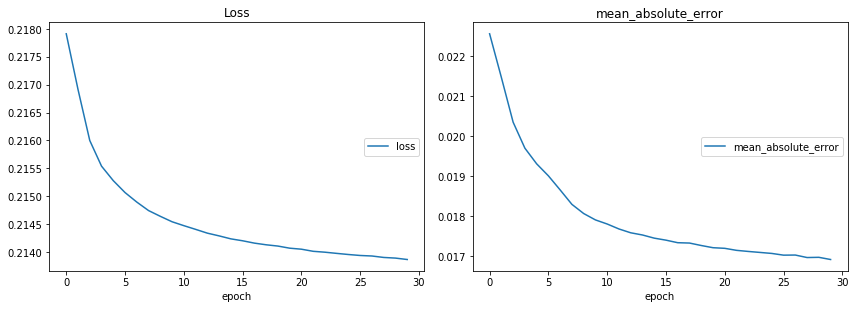

Loss
	loss             	 (min:    0.214, max:    0.225, cur:    0.214)
mean_absolute_error
	mean_absolute_error 	 (min:    0.017, max:    0.032, cur:    0.017)


In [ ]:
import tensorflow as tf

model.compile(
      optimizer='?',
      loss='?',
      metrics=['?'],
    )

model.fit_generator(it, epochs=30, callbacks = [PlotLossesKeras()])

Ya tenemos la red entrenada. Ahora podemos ver que resultado nos da:

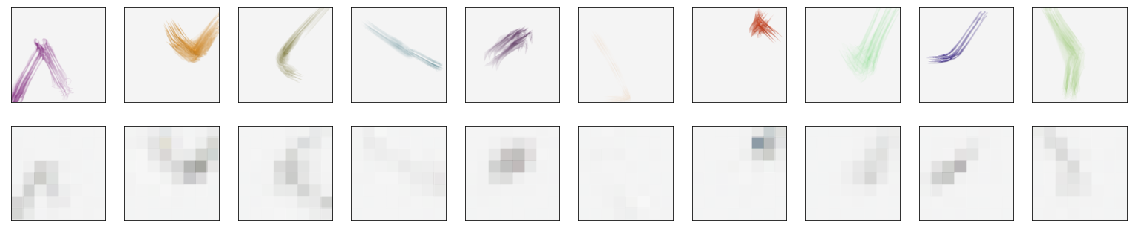

In [ ]:
batch = it.__next__()
pred = model.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Como era de esperar el resultado no es muy bueno ya que la red es muy sencilla pero es cuestión de buscar y encontrar una configuración que pueda funcionar mejor. Conoceis muchas opciones de arquitecturas: VGG, RESNET, U-NET, DenseNet, ... e incluso autocodificadores (modo 'ae'), autocodificadores condicionales (modo 'cae') y más interesante redes generativas.

### Normalización de los datos

A continuación, vamos a normalizar los datos con el fin de que todas las variables tengan el mismo rango de valores y por tanto el mismo peso en las redes construidas.

In [ ]:
strokes2 = strokes[['alpha', 'bristleCount', 'fluidity', 'hue', 'num_steps', 'saturation', 
           'scale', 'value', 'x1', 'x2', 'y1', 'y2', 'x3', 'y3']]

In [ ]:
strokes_norm = (strokes2-strokes2.mean())/strokes2.std()
strokes_norm['file_name'] = strokes['file_name']

In [ ]:
strokes_norm.describe()

alpha  bristleCount  ...            x3            y3
count  5.877800e+04  5.877800e+04  ...  5.877800e+04  5.877800e+04
mean   1.988746e-15  5.890615e-16  ...  3.210085e-17  7.210273e-17
std    1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00
min   -1.740613e+00 -1.564986e+00  ... -1.743100e+00 -1.726637e+00
25%   -8.650417e-01 -9.318324e-01  ... -8.593893e-01 -8.605951e-01
50%    1.975775e-05  1.789759e-02  ...  6.994095e-03 -2.919449e-02
75%    8.688543e-01  9.676276e-01  ...  8.560498e-01  8.541687e-01
max    1.730272e+00  1.600781e+00  ...  1.722433e+00  1.737532e+00

[8 rows x 14 columns]

Vamos a crear otros generadores a partir de los datos normalizados. 
   * De la misma manera, en este caso vamos a utilizar el modo *stroke*, el tamaño del mini-batch es de 32 y se aleatoriza las muestras cada vez que se genera.

In [ ]:
generador_norm = StrokeInMemoryIterator(im_bytes, strokes_norm, 32, mode='stroke', shuffle=True)

* En este caso utilizamos el modo *cae*, el tamaño del mini-batch es de 32 y se aleatoriza las muestras cada vez que se genera.

In [ ]:
generador_norm_cae = StrokeInMemoryIterator(im_bytes, strokes_norm, 32, mode='cae', shuffle=True)

In [ ]:
batch = generador_norm_cae.__next__()
batch[0][0].shape, batch[0][1].shape, batch[1].shape

((32, 128, 128, 3), (32, 14), (32, 128, 128, 3))

Por tanto, cada batch nos devuelve una lista de dos listas y otra lista: la primera contiene una con una lista con las 32 imágenes de la pincelada en RGB y otra lista con los 32 vectores de características de la pincelada de tamaño 14. La segunda lista contiene las 32 imágenes de la pincelada de tamaño 128x128x3 correspondientes a los vectores de características.

### Conversión HSV a RGB

A continuación, vamos a transformar el color en HSV a RGB con el fin de intentar que mejoren los resultados de la redes.

In [ ]:
rgb = pd.DataFrame(columns=['r','g','b'])
for x,y,z in zip(strokes['hue'],strokes['saturation'],strokes['value']):
  rgb.loc[len(rgb)]=list(colorsys.hsv_to_rgb(x,y,z))

In [ ]:
rgb.head()

r         g         b
0  0.06626  0.773216  0.066591
1  0.06626  0.773216  0.066591
2  0.06626  0.773216  0.066591
3  0.06626  0.773216  0.066591
4  0.06626  0.773216  0.066591

Eliminamos las variables *hue*, *saturation*, *value* de strokes y unimos este dataframe al rgb creado anteriormente.

In [ ]:
strokes_rgb = pd.concat([strokes.drop(['hue','saturation','value'],axis= 'columns'),rgb],axis=1)

Volvemos a normalizar los datos del dataframe anterior.

In [ ]:
strokes2_rgb = strokes_rgb[['alpha', 'bristleCount', 'fluidity', 'r','g','b', 'num_steps', 
           'scale', 'x1', 'x2', 'y1', 'y2', 'x3', 'y3']]

In [ ]:
strokes_norm_rgb = (strokes2_rgb-strokes2_rgb.mean())/strokes2_rgb.std()
strokes_norm_rgb['file_name'] = strokes_rgb['file_name']

Definimos un nuevo generador de imágenes para que tenga en cuenta las variables *r*, *g*, *b*.

In [ ]:
class StrokeInMemoryIterator_rgb(keras.utils.Sequence):
       
    def __init__(self, im_bytes, stroke_info, batch_size, shuffle=True,
                 input_shape=(128, 128), mode='stroke'):
        self.im_bytes = im_bytes
        self.stroke_info = stroke_info
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = input_shape
        self.mode = mode

        self.__len = int(stroke_info.shape[0] / self.batch_size)
        self.__features = ['alpha', 'bristleCount', 'fluidity', 'r','g','b', 'num_steps', 
           'scale', 'x1', 'x2', 'y1', 'y2', 'x3', 'y3']
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # entrada(s) y salida del batch
        info = self.stroke_info.iloc[indexes]
        stroke = info[self.__features].values
        y = [self.im_bytes[f] for f in info.file_name]
        

        # lista final de arrays
        y = self.preprocess_batch(y)
                
   
        # devolvemos el batch
        if self.mode == 'stroke':
            return stroke, y
        elif self.mode == 'ae':
            return y, y
        elif self.mode == 'cae':
            return [np.array(y), np.array(stroke)], y
        
    def preprocess_batch(self, batch):
        ims = []
        for im in batch:
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, self.input_shape) 
            ims.append(im)

        # normalizamos
        ims = np.array(ims).astype('float') / 255
        
        return ims
    
    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(self.stroke_info.shape[0]))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        return r

Por último, definimos nuestro nuevo generador que es de tipo *stroke*, el tamaño del mini-batch es 32 y se aleatoriza las muestras. 

In [ ]:
generador_norm_rgb= StrokeInMemoryIterator_rgb(im_bytes, strokes_norm_rgb, 32, mode='stroke', shuffle=True)

## VGG16

Vamos a comenzar construyendo la arquitectura de la red VGG16. Dicha arquitectura ha sido tomada del notebook *4.1. Fashion MNIST con regularización.ipynb* de clase y adaptada a nuestro problema, es decir, debe de recibir como entrada un vector de dimensión 14 y como salida una imagen con 3 canales (RGB).


In [ ]:
VGG16 = Sequential([
    Dense(32, activation='relu',input_shape=(14,)),
    Dense(2352, activation="relu"),
    Reshape((28,28,3)),

    # Bloque 1
    Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1'),
    Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'),

    # Bloque 2
    Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'),
    Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'),

    # Bloque 3
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'),
    Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'),

    # Bloque 4
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'),
    Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'),
    MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'),

    UpSampling2D((128,128)),                          
    Conv2D(3, (3,3), padding="same", activation='relu')   

])

VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 2352)              77616     
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 128)       7

In [ ]:
VGG16.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

VGG16.fit_generator(generador, epochs= 10, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.004, max:    0.172, cur:    0.004)
mean_absolute_error
	mean_absolute_error 	 (min:    0.028, max:    0.051, cur:    0.028)
1836/1836 [==============================] - 483s 263ms/step - loss: 0.0044 - mean_absolute_error: 0.0285


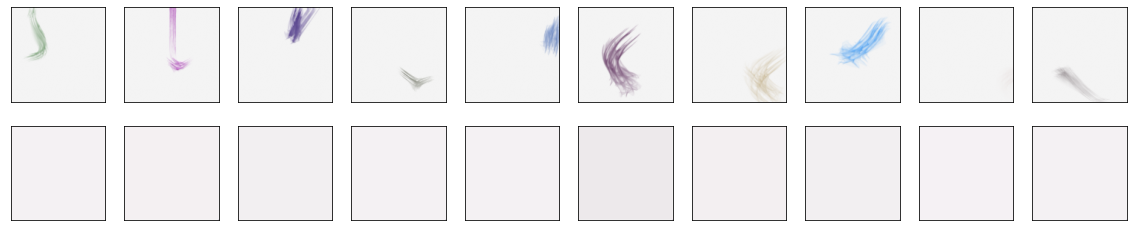

In [ ]:
batch = generador.__next__()
pred = VGG16.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Observamos que esta red no ha sido capaz de aprender sobre las pinceladas. Además, si observamos la gráfica del loss, vemos que a partir de la primera época no ha mejorado nada y por tanto es lógico que no haya aprendido. A continuación, vamos a modificar el loss con el fin de ver si la red es capaz de aprender algo.

* **Loss:** binary_crossentropy ;  **Métrica:** Mean absolute error

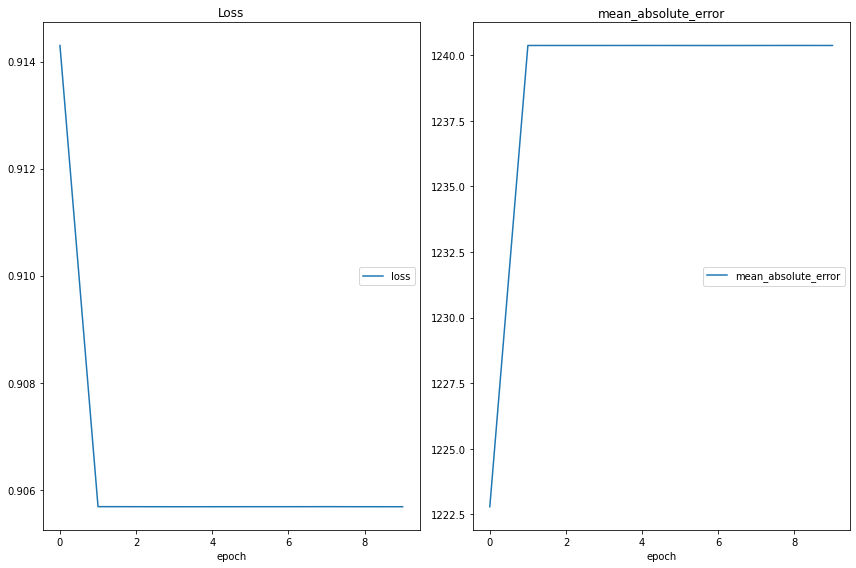

Loss
	loss             	 (min:    0.906, max:    0.914, cur:    0.906)
mean_absolute_error
	mean_absolute_error 	 (min: 1222.794, max: 1240.370, cur: 1240.369)
1836/1836 [==============================] - 150s 81ms/step - loss: 0.9057 - mean_absolute_error: 1240.3690


In [ ]:
VGG16.compile(optimizer= Adam(), loss = binary_crossentropy, metrics=['mean_absolute_error'])

VGG16.fit_generator(generador, epochs= 10, callbacks = [PlotLossesKeras()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

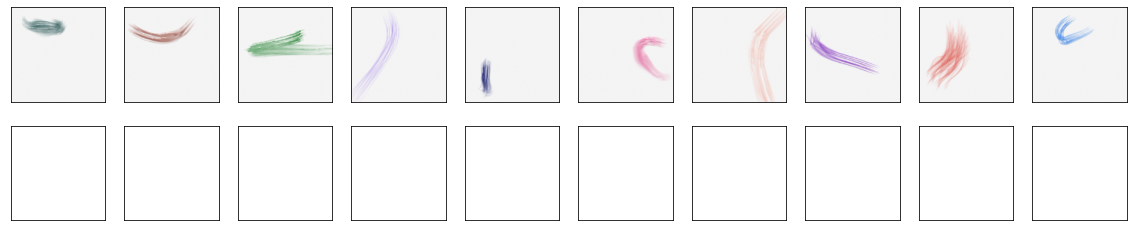

In [ ]:
batch = generador.__next__()
pred = VGG16.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

* **Loss:** Mean squared error ;  **Métrica:** ssim_loss

In [ ]:
VGG16.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=[ssim_loss],
    )

VGG16.fit_generator(generador, epochs= 10, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.004, max: 1022.177, cur:    0.004)
ssim_loss
	ssim_loss        	 (min:    0.943, max:      inf, cur:    0.943)
1836/1836 [==============================] - 169s 92ms/step - loss: 0.0044 - ssim_loss: 0.9432


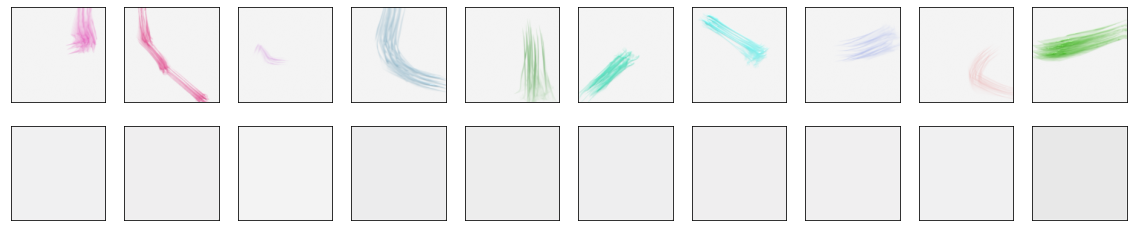

In [ ]:
batch = generador.__next__()
pred = VGG16.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Vemos que en ambos casos pasa lo mismo que antes, es decir, el loss se estabiliza en la primera época y por tanto la red no aprende nada de la pincelada. Por tanto, parece ser que la arquitectura de esta red no es adecuada para nuestro objetivo y en consecuencia no vamos a guardar los pesos de ninguna de las anteriores redes.

## Autoencoder: Descodificador

A continuación, vamos a definir la arquitectura del descodificador del autoencoder. Dicha arquitectura ha sido tomada del notebook *Autoencodificadores.ipynb* de clase y adaptada a nuestro problema, es decir, debe de recibir como entrada un vector de dimensión 14 y como salida una imagen con 3 canales (RGB).

In [ ]:
features = Input(shape=(14,))
x = Dense(4096,activation="relu")(features)
x = Reshape((8,8,64))(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_5'
            )(x)
# x = BatchNormalization()(x)
# x = Dropout(self.dropout)(x)

decoder = Model(features, x)
decoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              61440     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)       

In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

decoder.fit_generator(generador, epochs= 50, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.002, max:    0.002, cur:    0.002)
mean_absolute_error
	mean_absolute_error 	 (min:    0.014, max:    0.016, cur:    0.014)
1836/1836 [==============================] - 60s 33ms/step - loss: 0.0021 - mean_absolute_error: 0.0145


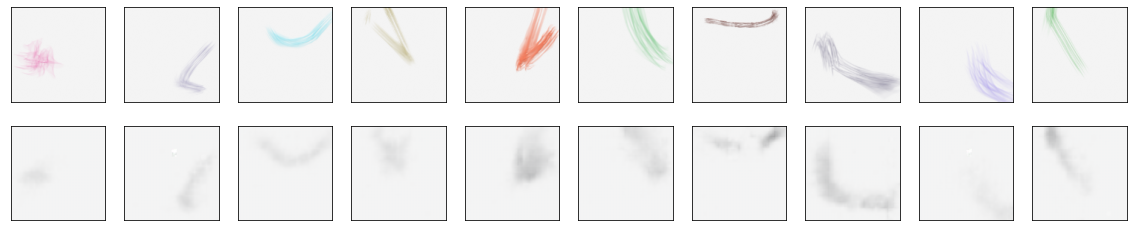

In [ ]:
batch = generador.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos observar que en este caso ha aprendido un poco de la trayectoria aunque lejos de parecerse la pincelada al original. A continuación, vamos a entrenar esta red utilizando los datos normalizados con el fin de intentar que aprenda de los colores y pincel. 

### Utilizando los datos normalizados

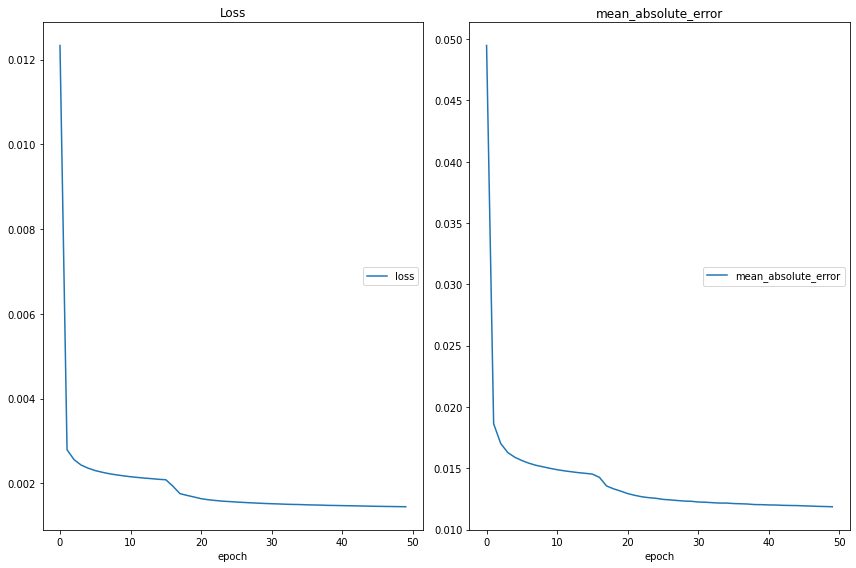

Loss
	loss             	 (min:    0.001, max:    0.012, cur:    0.001)
mean_absolute_error
	mean_absolute_error 	 (min:    0.012, max:    0.049, cur:    0.012)
1836/1836 [==============================] - 81s 44ms/step - loss: 0.0014 - mean_absolute_error: 0.0119


In [ ]:
decoder.compile(
      optimizer='adam',
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

decoder.fit_generator(generador_norm, epochs= 50, callbacks = [PlotLossesKeras()])

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

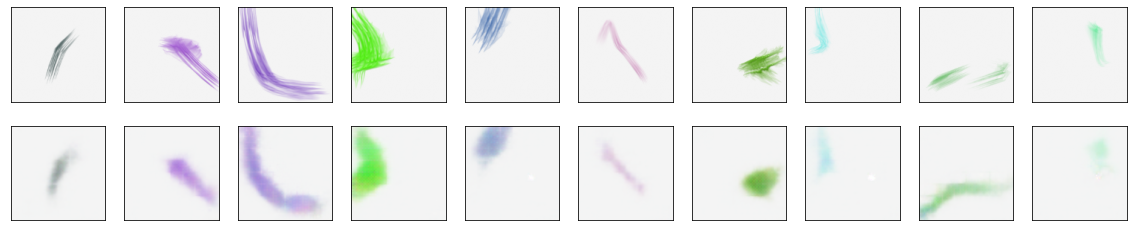

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que en este caso aprende bastante bien de la trayectoria, del color y un poco de la transparencia. Lo que no acaba de aprender es el pincel.

A continuación, vamos a guardar los pesos de esta red:

In [ ]:
model_json=decoder.to_json()
with open("decoder.json","w") as json_file:
    json_file.write(model_json)
decoder.save_weights("decoder.h5")

El siguiente código es para cargar la red guardada:

In [ ]:
json_file = open("decoder.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("decoder.h5")

loaded_model.compile(
      optimizer='adam',
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

### Variando el loss y la métrica

 A continuación, vamos a variar el loss y la métrica con el fin de intentar que esta red aprenda del pincel.

* **Loss:** mean squared error ;  **Métrica:** ssim_loss

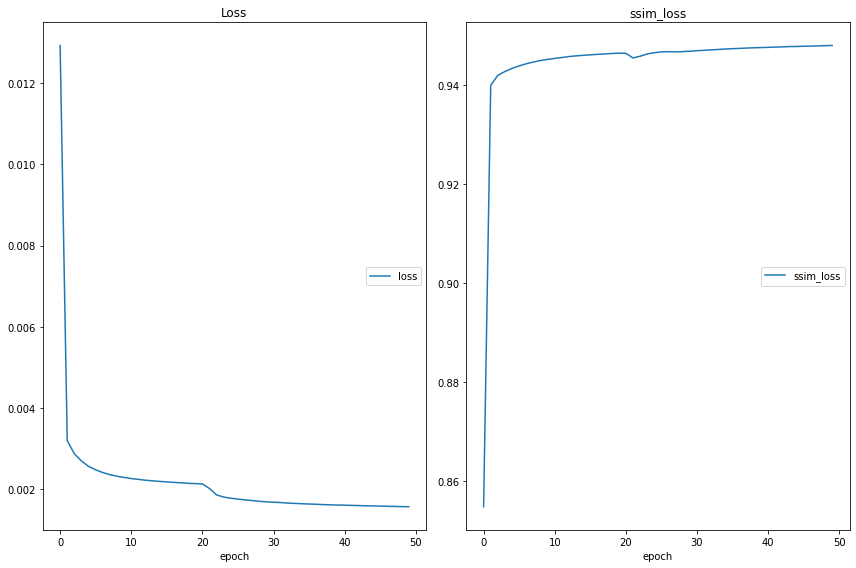

Loss
	loss             	 (min:    0.002, max:    0.013, cur:    0.002)
ssim_loss
	ssim_loss        	 (min:    0.855, max:    0.948, cur:    0.948)
1836/1836 [==============================] - 87s 48ms/step - loss: 0.0016 - ssim_loss: 0.9480


In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=[ssim_loss],
    )

decoder.fit_generator(generador_norm, epochs= 50, callbacks = [PlotLossesKeras()])

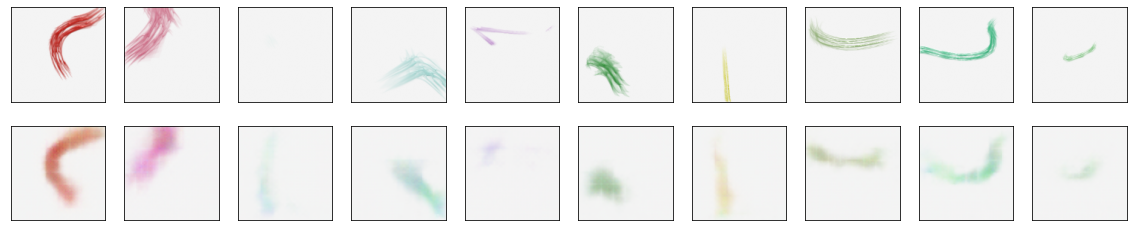

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Vemos que sigue aprendiendo de la trayectoria, color y transparencia pero no consigue aprender del pincel.

* **Loss:** MSE + ssim_loss ; **Métrica:** cosine_similarity

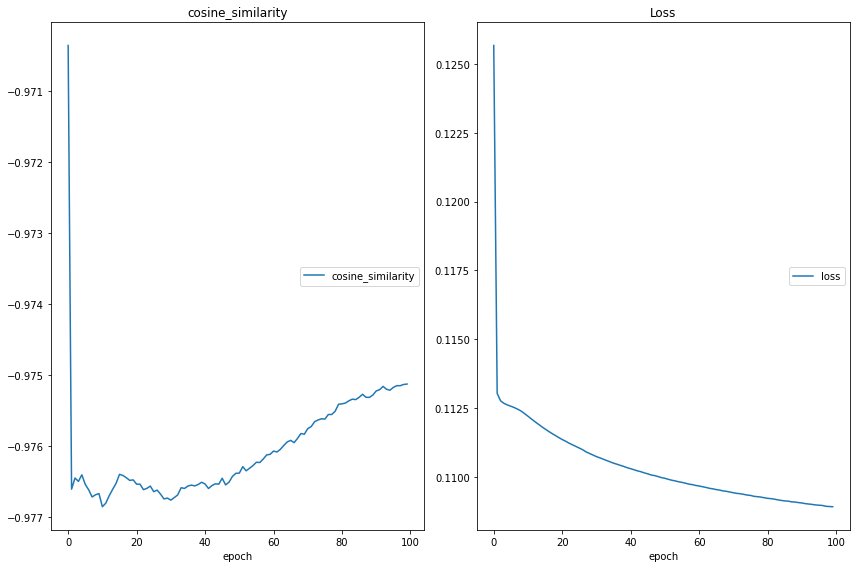

cosine_similarity
	cosine_similarity 	 (min:   -0.977, max:   -0.970, cur:   -0.975)
Loss
	loss             	 (min:    0.109, max:    0.126, cur:    0.109)
1836/1836 [==============================] - 105s 57ms/step - loss: 0.1089 - cosine_similarity: -0.9751


In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss=MSE_ssim_loss,
      metrics=[cosine_similarity],
    )

decoder.fit_generator(generador_norm, epochs= 100, callbacks = [PlotLossesKeras()])

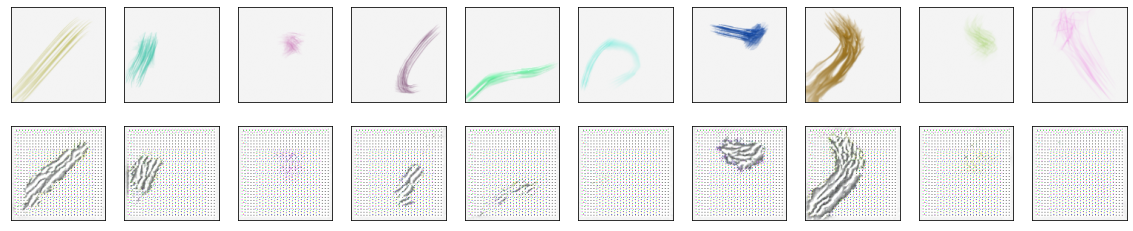

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

En este caso sin embargo observamos que aprende un poco más del pincel manteniendo la trayectoría (aunque un poco robusta) pero el color se ha perdido y un poco la 'realidad' de la pincelada.

* **Loss:** MSE + binary_crossentropy ; **Métrica:** Mean absolute error

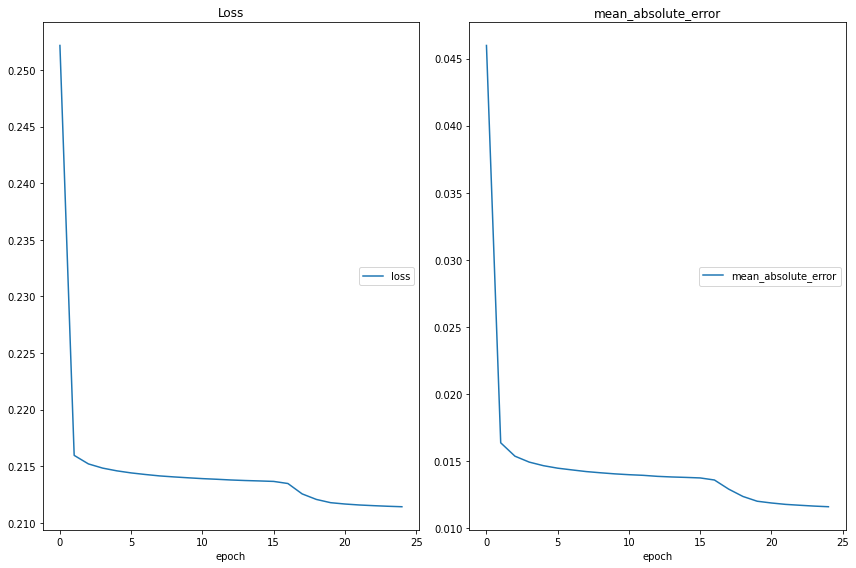

Loss
	loss             	 (min:    0.211, max:    0.252, cur:    0.211)
mean_absolute_error
	mean_absolute_error 	 (min:    0.012, max:    0.046, cur:    0.012)
1836/1836 [==============================] - 79s 43ms/step - loss: 0.2114 - mean_absolute_error: 0.0116


In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss= MSE_binary_crossentropy,
      metrics=['mean_absolute_error'],
    )

decoder.fit_generator(generador_norm, epochs= 25, callbacks = [PlotLossesKeras()])

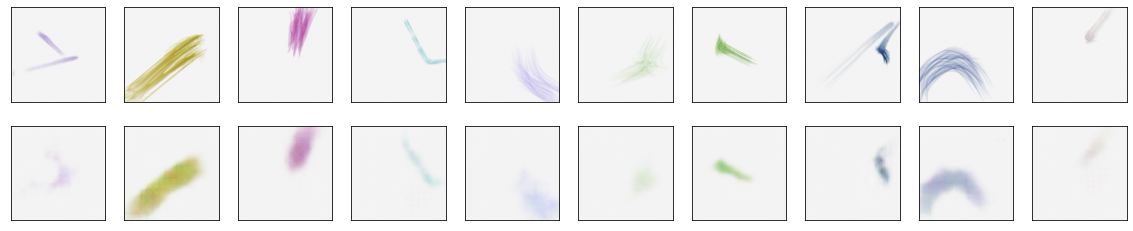

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Volvemos a conseguir la trayectoria, el color y la transparencia pero del pincel sigue sin aprender esta red.

* **Loss:** Mean squared logarithmic error; **Métrica:** Mean absolute error


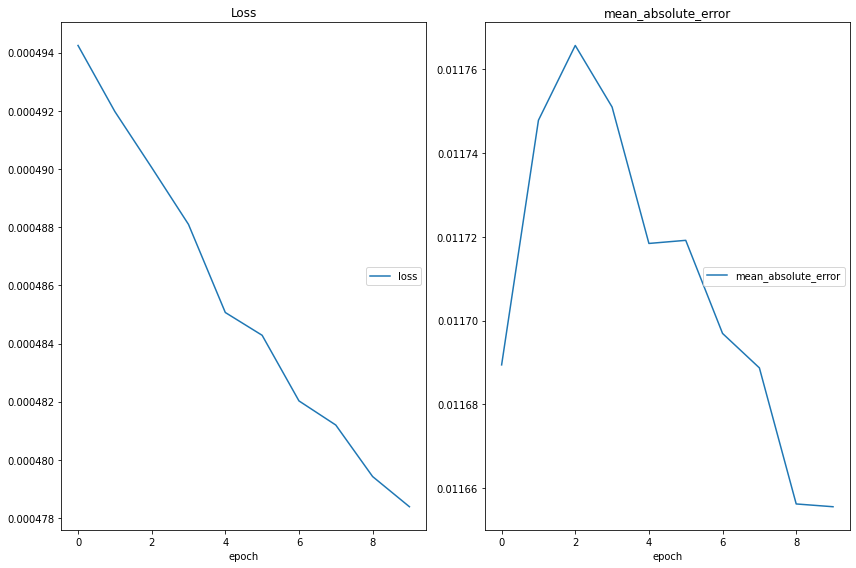

Loss
	loss             	 (min:    0.000, max:    0.000, cur:    0.000)
mean_absolute_error
	mean_absolute_error 	 (min:    0.012, max:    0.012, cur:    0.012)
1836/1836 [==============================] - 82s 44ms/step - loss: 4.7839e-04 - mean_absolute_error: 0.0117


In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss= tf.keras.losses.MeanSquaredLogarithmicError(),
      metrics=['mean_absolute_error'],
    )

decoder.fit_generator(generador_norm, epochs= 10, callbacks = [PlotLossesKeras()])

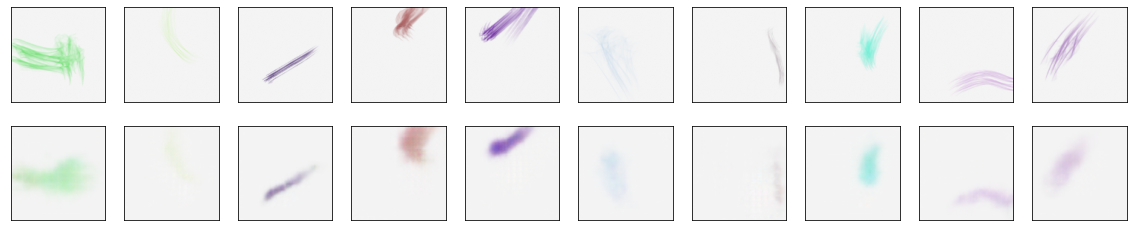

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

No conseguimos nada nuevo e incluso en este caso empeora la claridad de la trayectoria en algunos casos.

* **Loss:** MSE + cosine_similarity; **Métrica:** ssim_loss

In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss= MSE_cosine_similarity,
      metrics=[ssim_loss],
    )

decoder.fit_generator(generador_norm, epochs= 10, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:   -0.998, max:   -0.998, cur:   -0.998)
ssim_loss
	ssim_loss        	 (min:    0.950, max:    0.951, cur:    0.951)
1836/1836 [==============================] - 88s 48ms/step - loss: -0.9983 - ssim_loss: 0.9507


In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Volvemos a conseguir la trayectoria, el color y la transparencia pero del pincel sigue sin aprender esta red.

* **Loss:** Mean squared logarithmic error; **Métrica:** ssim_loss

In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss= tf.keras.losses.MeanSquaredLogarithmicError(),
      metrics=[ssim_loss],
    )

decoder.fit_generator(generador_norm, epochs= 10, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.001, max:    0.001, cur:    0.001)
ssim_loss
	ssim_loss        	 (min:    0.887, max:    0.946, cur:    0.946)
1836/1836 [==============================] - 58s 32ms/step - loss: 7.2824e-04 - ssim_loss: 0.9463


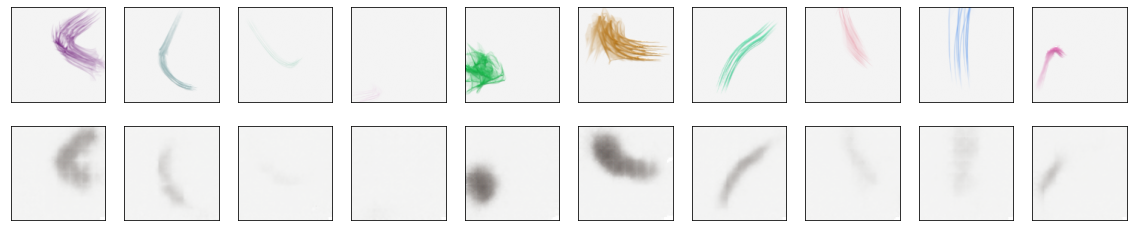

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

En este caso sigue manteniendo la trayectoria aunque empeora con respecto a los de antes. Además perdemos el color y sigue sin aprender del pincel.

* **Loss:** 0.3*MSE + 0.7*ssim_loss; **Métrica:** Mean squared error

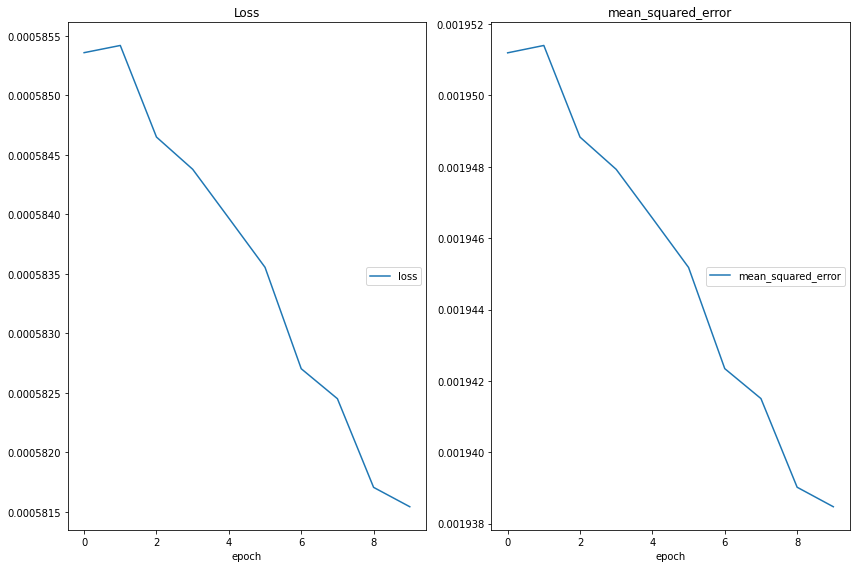

Loss
	loss             	 (min:    0.001, max:    0.001, cur:    0.001)
mean_squared_error
	mean_squared_error 	 (min:    0.002, max:    0.002, cur:    0.002)
1836/1836 [==============================] - 92s 50ms/step - loss: 5.8154e-04 - mean_squared_error: 0.0019


In [ ]:
decoder.compile(
      optimizer= Adam()
      loss= [MSE,ssim_loss],
      loss_weights = [0.3,0.7],
      metrics=['mean_squared_error'],
    )

decoder.fit_generator(generador_norm, epochs= 10, callbacks = [PlotLossesKeras()])

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

 En este caso empeora un poco los resultados ya que aunque se sigue manteniendo la trayectoria, el color se ha perdido y del pincel no aprende nada.

* **Loss:** LogCosh (logaritmo coseno hiperbólico); **Métrica:** Mean absolute error

In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss= tf.keras.losses.LogCosh(),
      metrics=['mean_absolute_error'],
    )

decoder.fit_generator(generador_norm, epochs= 10, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.001, max:    0.002, cur:    0.001)
mean_absolute_error
	mean_absolute_error 	 (min:    0.016, max:    0.022, cur:    0.016)
1836/1836 [==============================] - 64s 35ms/step - loss: 0.0011 - mean_absolute_error: 0.0158


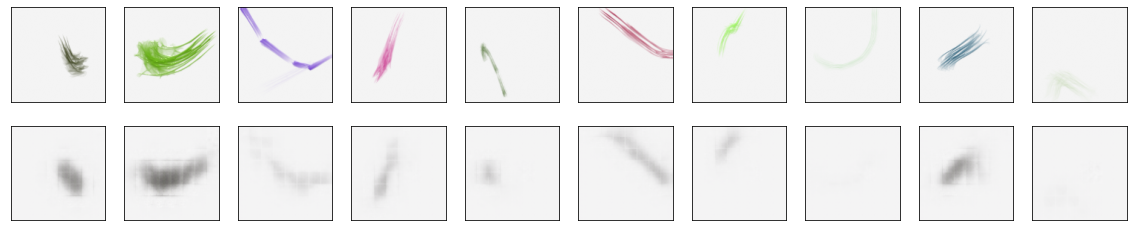

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Ocurre lo mismo de antes, la trayectoria es lo único que aprende.

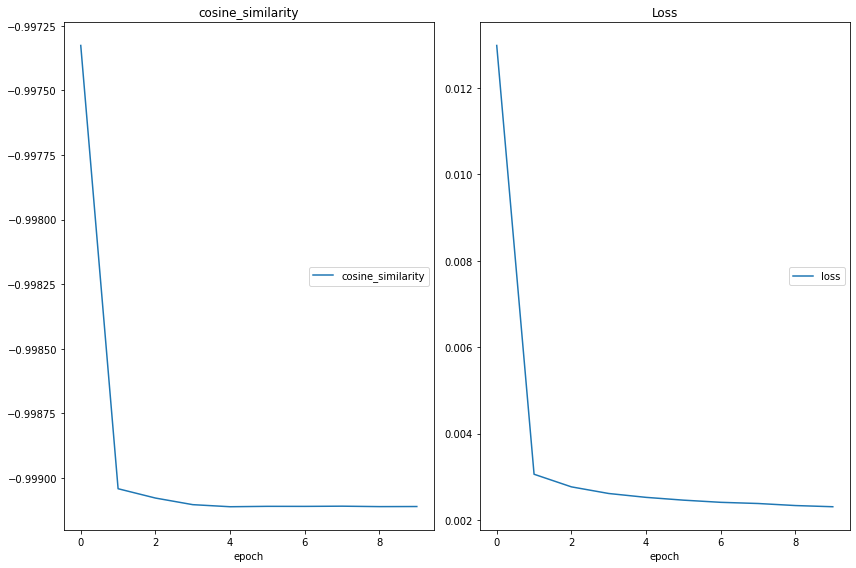

cosine_similarity
	cosine_similarity 	 (min:   -0.999, max:   -0.997, cur:   -0.999)
Loss
	loss             	 (min:    0.002, max:    0.013, cur:    0.002)
1836/1836 [==============================] - 60s 33ms/step - loss: 0.0023 - cosine_similarity: -0.9991


In [ ]:
decoder.compile(
      optimizer=Adam(),
      loss= 'mean_squared_error',
      metrics=[cosine_similarity],
    )

decoder.fit_generator(generador_norm, epochs= 10, callbacks = [PlotLossesKeras()])

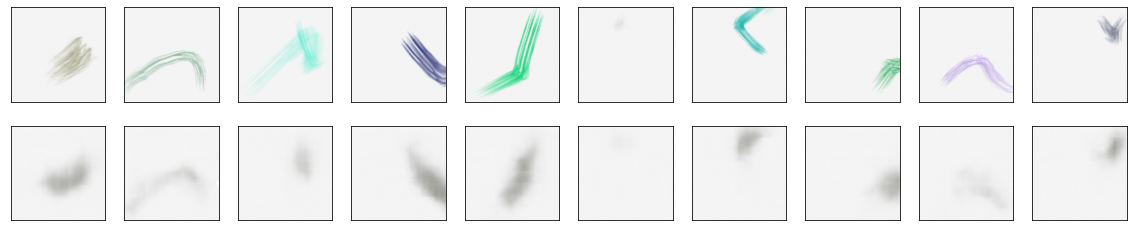

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que en este caso sólo aprende de la trayectoria también.

### Utilizando los puntos intermedios

A continuación, vamos a utilizar el vector de características con los puntos intermedios como dato de entrada con el fin de que la red aprenda mejor las pinceladas. Es decir, vamos a dejar la misma estructura de antes pero cambiando el tamaño de entrada a 28.

In [ ]:
features = Input(shape=(28,))
x = Dense(4096,activation="relu")(features)
x = Reshape((8,8,64))(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_5'
            )(x)

decoder = Model(features, x)
decoder.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              118784    
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 64)       

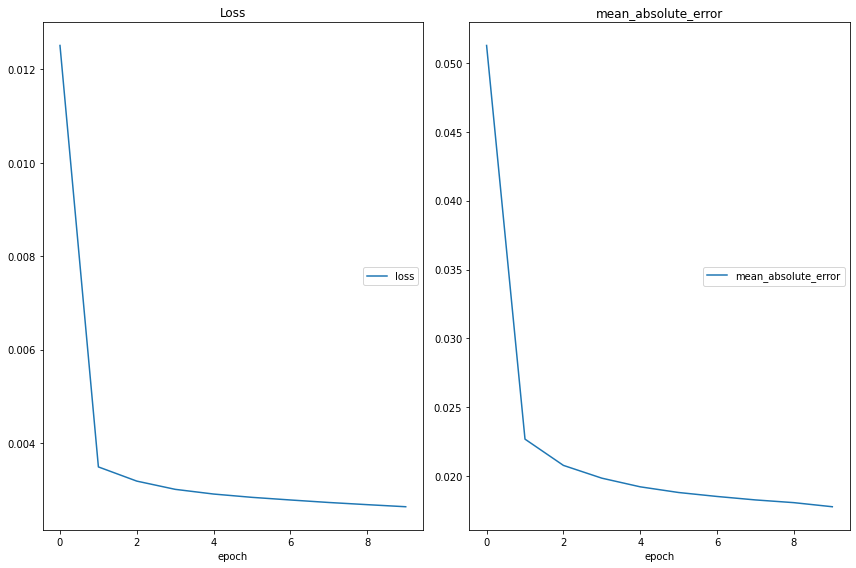

Loss
	loss             	 (min:    0.003, max:    0.013, cur:    0.003)
mean_absolute_error
	mean_absolute_error 	 (min:    0.018, max:    0.051, cur:    0.018)
1836/1836 [==============================] - 83s 45ms/step - loss: 0.0026 - mean_absolute_error: 0.0178


In [ ]:
decoder.compile(
      optimizer='adam',
      loss= 'mean_squared_error',
      metrics=['mean_absolute_error'],
    )

decoder.fit_generator(generador_norm_punt_inter, epochs=10, callbacks = [PlotLossesKeras()])

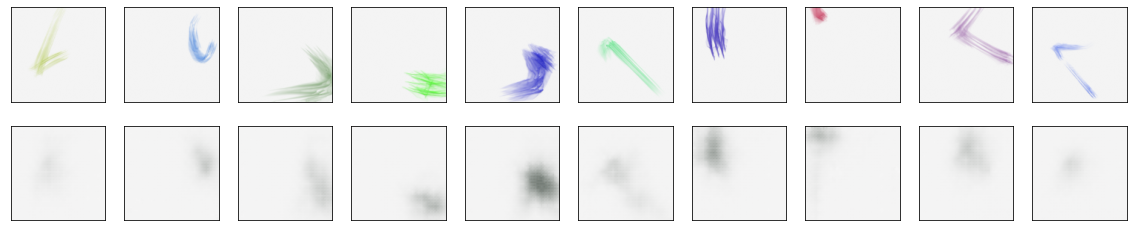

In [ ]:
batch = generador_norm_punt_inter.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Como podemos observar, los resultados han empeorado bastantes e incluso ya ni la trayectoria la aprende. A continuación, vamos a modificar la arquitectura con el fin de intentar obtener mejores resultados.

In [ ]:
features = Input(shape=(28,))
x = Dense(1024,activation="relu")(features)
x = Reshape((4,4,64))(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization(momentum=0.9)(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization(momentum=0.9)(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization(momentum=0.9)(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization(momentum=0.9)(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_5' 
            )(x)
x = BatchNormalization(momentum=0.9)(x)
x =  Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_6'
            )(x)

decoder_punt_intermedios = Model(features, x)
decoder_punt_intermedios.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              29696     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 4, 4, 64)          36928     
_________________________________________________________________
batch_normalization_5 (Batch (None, 4, 4, 64)          256       
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 64)         

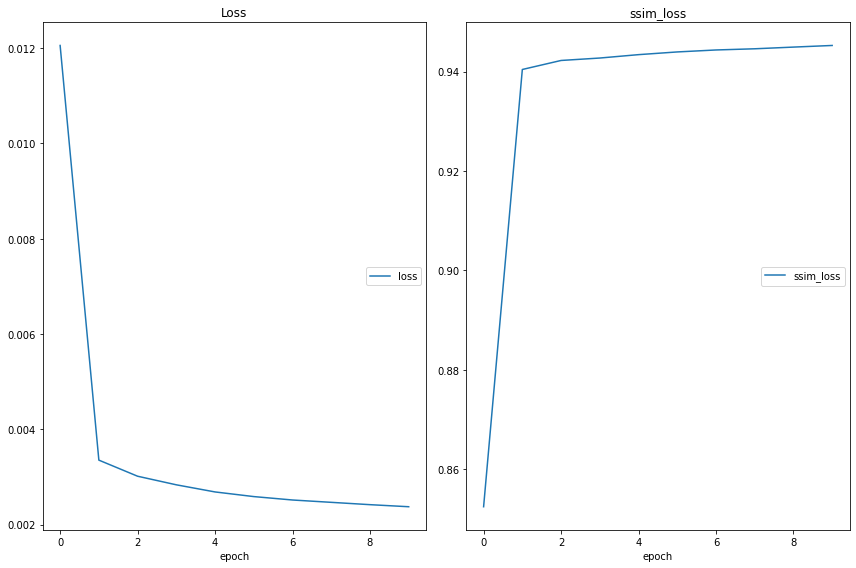

Loss
	loss             	 (min:    0.002, max:    0.012, cur:    0.002)
ssim_loss
	ssim_loss        	 (min:    0.852, max:    0.945, cur:    0.945)
1836/1836 [==============================] - 78s 43ms/step - loss: 0.0024 - ssim_loss: 0.9452


In [ ]:
decoder_punt_intermedios.compile(
      optimizer=Adam(),
      loss= 'mean_squared_error',
      metrics=[ssim_loss],
    )

decoder_punt_intermedios.fit_generator(generador_norm_punt_inter, epochs=10, callbacks = [PlotLossesKeras()])

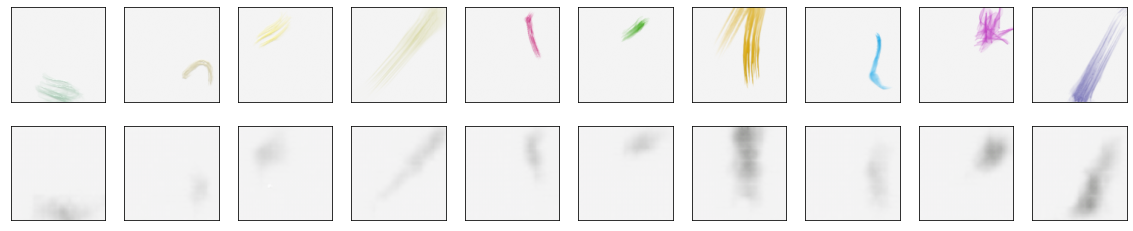

In [ ]:
batch = generador_norm_punt_inter.__next__()
pred = decoder_punt_intermedios.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

En este caso ha mejorado un poco la trayectoria pero lejos a parecerse al original. Además sigue sin aprender del color ni pincel. A continuación, vamos a cambiar el loss y la métrica con el fin de intentar mejorar los resultados.

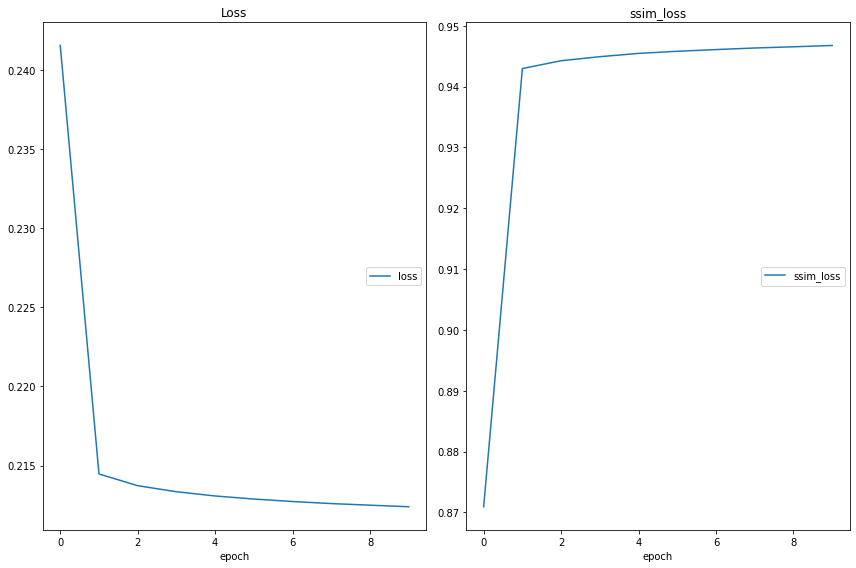

Loss
	loss             	 (min:    0.212, max:    0.242, cur:    0.212)
ssim_loss
	ssim_loss        	 (min:    0.871, max:    0.947, cur:    0.947)
1836/1836 [==============================] - 92s 50ms/step - loss: 0.2124 - ssim_loss: 0.9468


In [ ]:
decoder_punt_intermedios.compile(
      optimizer= Adam(),
      loss=binary_crossentropy,
      metrics=[ssim_loss],
    )

decoder_punt_intermedios.fit_generator(generador_norm_punt_inter, epochs=10, callbacks = [PlotLossesKeras()])

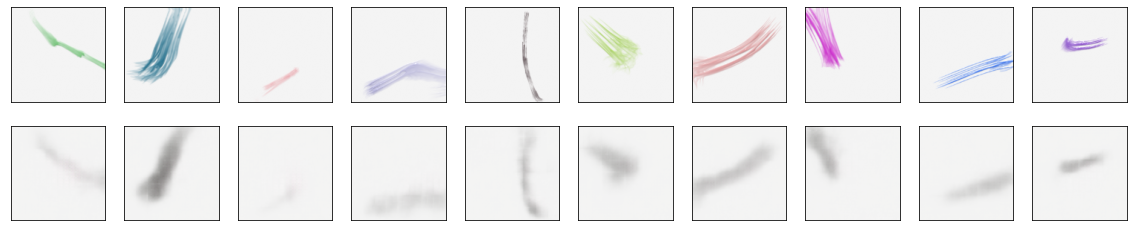

In [ ]:
batch = generador_norm_punt_inter.__next__()
pred = decoder_punt_intermedios.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que la cosa no ha mejorado ya que sólo aprende de la trayectoria de la pincelada.

## ResNet

A continuación, vamos a definir la arquitectura de la ResNet. Dicha arquitectura ha sido tomada del notebook *3_1_MNIST_convolucional_2.ipynb* de clase y adaptada a nuestro problema, es decir, debe de recibir como entrada un vector de dimensión 14 y como salida una imagen con 3 canales (RGB).

In [ ]:
def residual(kernels, x):
    y = Conv2D(kernels, (3, 3), padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2D(kernels, (3, 3), padding='same')(y)
    y = BatchNormalization()(y)
    
    #suma x + y -> z = x + conv(x)
    z = keras.layers.add([x, y])
    z = Activation('relu')(z)
    
    return z

In [ ]:
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model

features = Input((14,))
x = Dense(32*32,activation = "relu")(features)
x = Reshape((32,32,1))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = residual(32, x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = residual(32, x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = residual(32, x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)             
x = residual(32, x)
x = residual(32, x)
x = residual(32, x)
x = UpSampling2D((32,32))(x)                        
salida = Conv2D(3, (3,3), padding="same", activation='relu')(x)

model_resnet = Model(features, salida)

model_resnet.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 1024)         15360       input_6[0][0]                    
__________________________________________________________________________________________________
reshape_26 (Reshape)            (None, 32, 32, 1)    0           dense_30[0][0]                   
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 32, 32, 32)   320         reshape_26[0][0]                 
_______________________________________________________________________________________

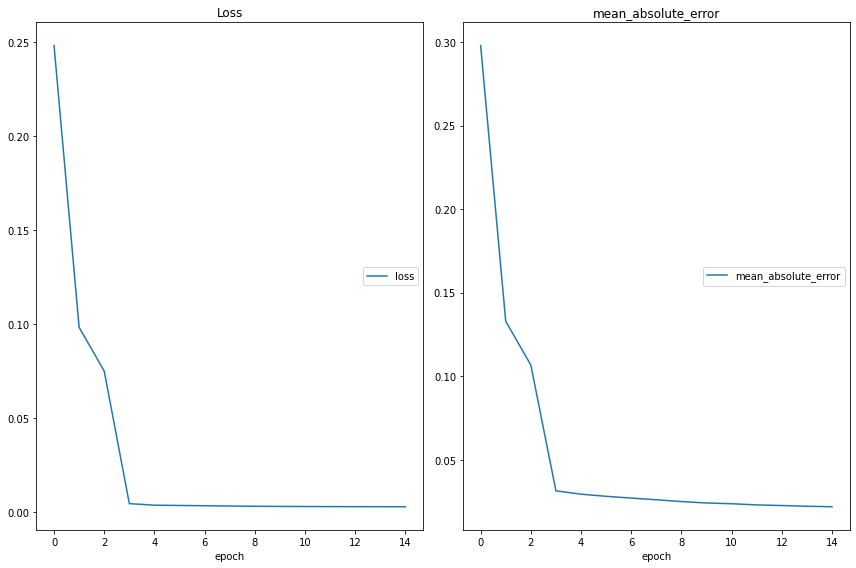

Loss
	loss             	 (min:    0.003, max:    0.248, cur:    0.003)
mean_absolute_error
	mean_absolute_error 	 (min:    0.022, max:    0.298, cur:    0.022)
1836/1836 [==============================] - 68s 37ms/step - loss: 0.0028 - mean_absolute_error: 0.0219


In [ ]:
model_resnet.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

model_resnet.fit_generator(generador_norm, epochs= 15, callbacks = [PlotLossesKeras()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

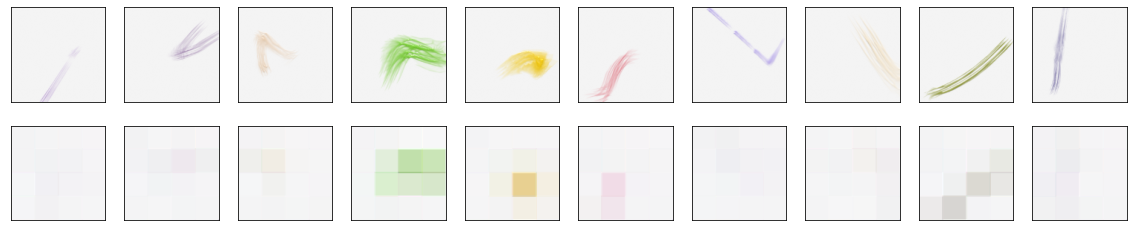

In [ ]:
batch = generador_norm.__next__()
pred = model_resnet.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Observamos unos resultados bastantes malos aunque aprende bastante bien del color. En consecuencia, esta red no es adecuada para nuestro objetivo. A continuación, vamos a modificar su arquitectura cambiando las convoluciones por deconvoluciones y veamos si obtenemos mejores resultados.

## ResNet con deconvoluciones

In [ ]:
def residual2(kernels, x):
    y = Conv2DTranspose(kernels, (3, 3), padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Conv2DTranspose(kernels, (3, 3), padding='same')(y)
    y = BatchNormalization()(y)
    
    #suma x + y -> z = x + conv(x)
    z = keras.layers.add([x, y])
    z = Activation('relu')(z)
    
    return z

In [ ]:
features = Input((14,)) 
x = Dense(64,activation = "relu")(features)
x = Reshape((8,8,1))(x)
x = Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization() (x)
x = residual2(64, x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization()(x)
x = residual2(64, x)
x = Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization()(x)
x = residual2(32, x)
x = Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization()(x)          
x = residual2(32, x)
x = residual2(32, x)
x = residual2(32, x)                       
salida  = Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_5' 
            )(x)

model_resnet_decov = Model(features, salida)

model_resnet_decov.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           960         input_9[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 8, 8, 1)      0           dense_8[0][0]                    
__________________________________________________________________________________________________
decoder_conv_1 (Conv2DTranspose (None, 8, 8, 64)     640         reshape_6[0][0]                  
______________________________________________________________________________________

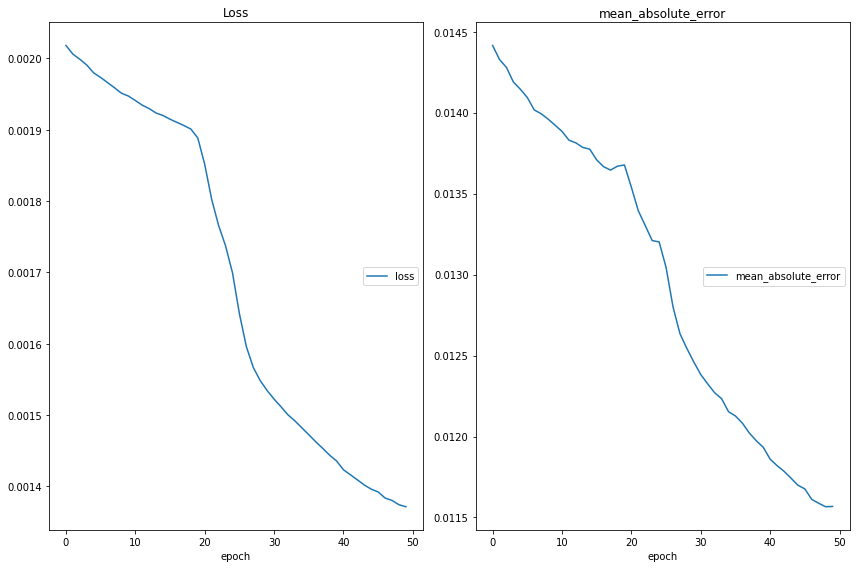

Loss
	loss             	 (min:    0.001, max:    0.002, cur:    0.001)
mean_absolute_error
	mean_absolute_error 	 (min:    0.012, max:    0.014, cur:    0.012)
1836/1836 [==============================] - 78s 42ms/step - loss: 0.0014 - mean_absolute_error: 0.0116


In [ ]:
model_resnet_decov.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

model_resnet_decov.fit_generator(generador_norm, epochs= 50, callbacks = [PlotLossesKeras()])

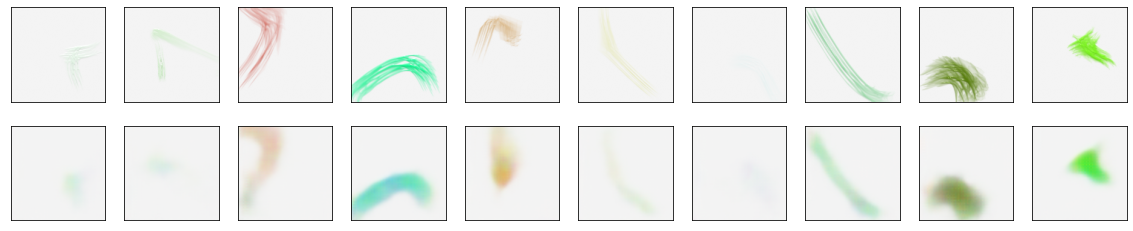

In [ ]:
batch = generador_norm.__next__()
pred = model_resnet_decov.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Vemos que ahora han mejorado los resultados, aprende de la trayectoria y del color aunque no del todo parecido. Esta red tampoco llega aprender del pincel. A continuación, vamos a variar el loss con el fin de intentar obtener mejores resultados.

* **Loss:** binary crossentropy ;  **Métrica:** mean absolute error

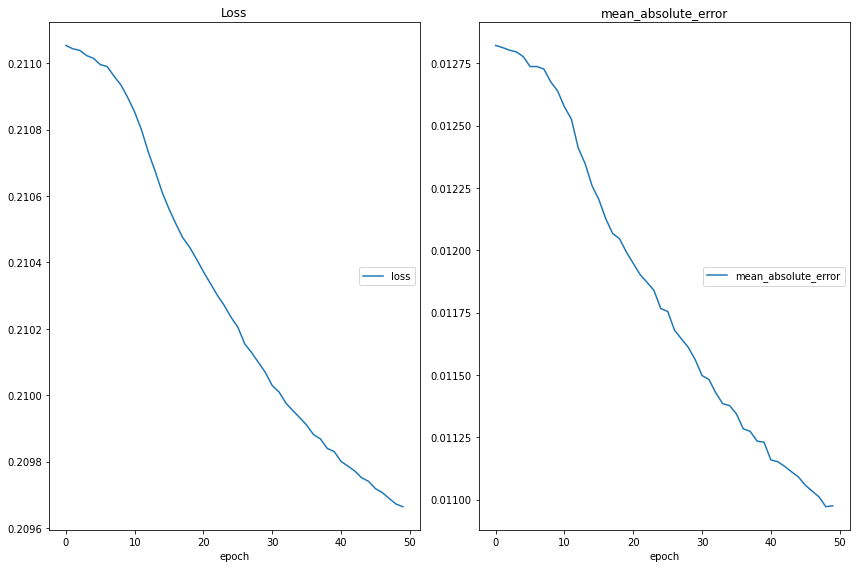

Loss
	loss             	 (min:    0.210, max:    0.211, cur:    0.210)
mean_absolute_error
	mean_absolute_error 	 (min:    0.011, max:    0.013, cur:    0.011)
1836/1836 [==============================] - 147s 80ms/step - loss: 0.2097 - mean_absolute_error: 0.0110


In [ ]:
model_resnet_decov.compile(
      optimizer=Adam(),
      loss=binary_crossentropy,
      metrics=['mean_absolute_error'],
    )

model_resnet_decov.fit_generator(generador_norm, epochs= 50, callbacks = [PlotLossesKeras()])

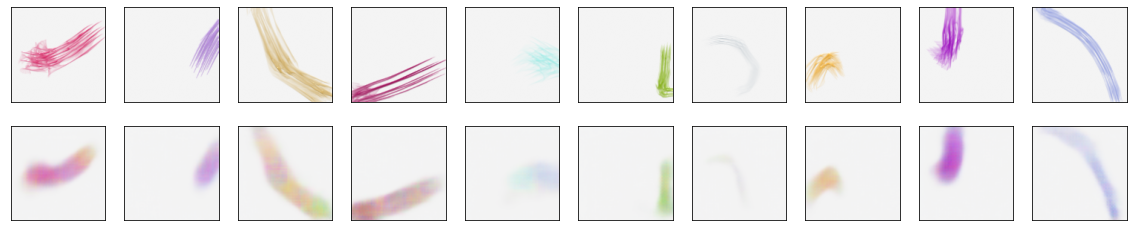

In [ ]:
batch = generador_norm.__next__()
pred = model_resnet_decov.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que sigue aprendiendo de la trayectoria pero el color aunque lo aprende, en algunos casos lo vemos un poco ambiguo. Además no llega a aprender del pincel. A continuación, vamos a volver a realizar el entrenamiento pero usamos la conversión HSV a RGB en el vector de características.

### Utilizando conversión HSV a RGB

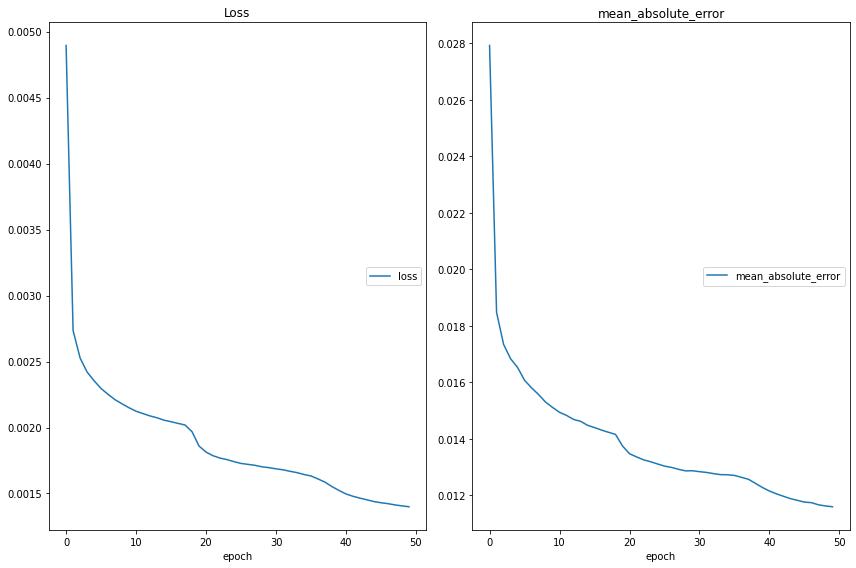

Loss
	loss             	 (min:    0.001, max:    0.005, cur:    0.001)
mean_absolute_error
	mean_absolute_error 	 (min:    0.012, max:    0.028, cur:    0.012)
1836/1836 [==============================] - 79s 43ms/step - loss: 0.0014 - mean_absolute_error: 0.0116


In [ ]:
model_resnet_decov.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

model_resnet_decov.fit_generator(generador_norm_rgb, epochs= 50, callbacks = [PlotLossesKeras()])

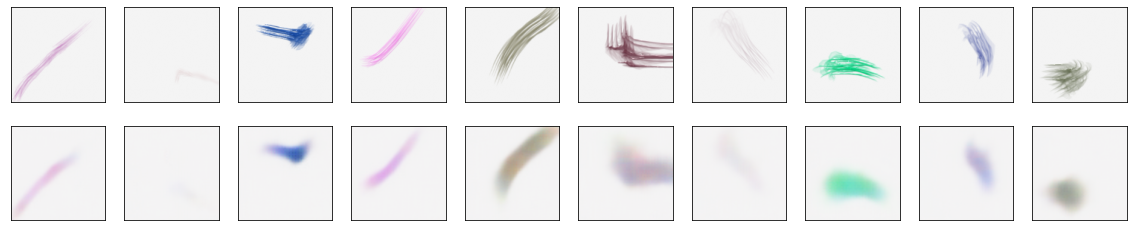

In [ ]:
batch = generador_norm_rgb.__next__()
pred = model_resnet_decov.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que ahora sí que aprende el color correctamente además de la trayectoria. Sin embargo sigue sin aprender del pincel, por tanto, a continuación, vamos a cambiar el loss con el fin de intentar obtener mejores resultados.

Vamos a guardar los pesos de esta red:

In [ ]:
model_json=model_resnet_decov.to_json()
with open("resnet_decov.json","w") as json_file:
    json_file.write(model_json)
model_resnet_decov.save_weights("resnet_decov.h5")

El siguiente código es para cargar la red guardada:

In [ ]:
json_file = open("resnet_decov.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("resnet_decov.h5")

loaded_model.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

* **Loss:** binary crossentropy; **Métrica:** mean absolute error

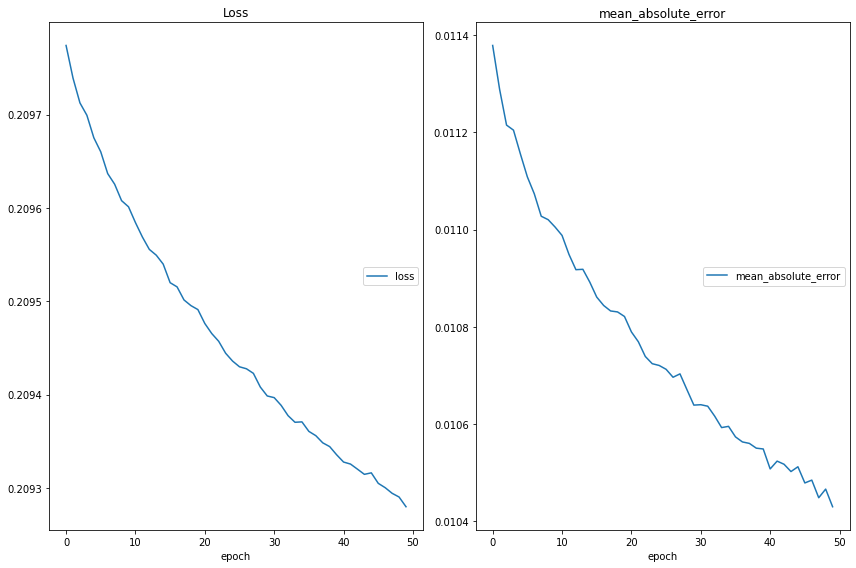

Loss
	loss             	 (min:    0.209, max:    0.210, cur:    0.209)
mean_absolute_error
	mean_absolute_error 	 (min:    0.010, max:    0.011, cur:    0.010)
1836/1836 [==============================] - 150s 82ms/step - loss: 0.2093 - mean_absolute_error: 0.0104


In [ ]:
model_resnet_decov.compile(
      optimizer=Adam(),
      loss=binary_crossentropy,
      metrics=['mean_absolute_error'],
    )

model_resnet_decov.fit_generator(generador_norm_rgb, epochs= 50, callbacks = [PlotLossesKeras()])

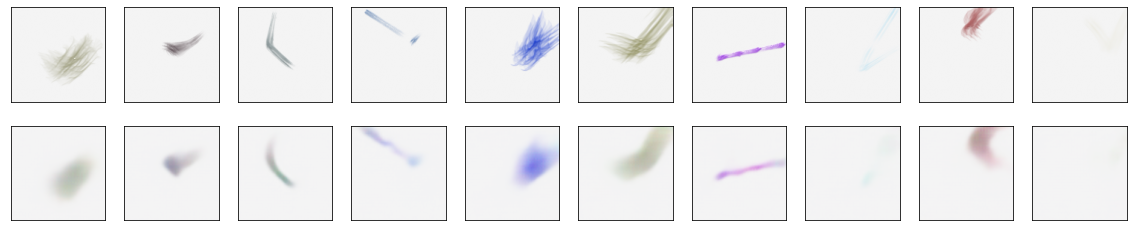

In [ ]:
batch = generador_norm_rgb.__next__()
pred = model_resnet_decov.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que los resultados no mejoran a lo anterior ya que sigue aprendiendo de la trayectoria y color pero no del pincel.

### Utilizando los puntos intermedios

A continuación, vamos a utilizar el vector de características con los puntos intermedios como entrada con el fin de intentar obtener mejores resultados.

In [ ]:
features = Input((28,)) 
x = Dense(64,activation = "relu")(features)
x = Reshape((8,8,1))(x)
x = Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization() (x)
x = residual2(64, x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization()(x)
x = residual2(64, x)
x = Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization()(x)
x = residual2(32, x)
x = Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization()(x)          
x = residual2(32, x)
x = residual2(32, x)
x = residual2(32, x)                       
salida  = Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_5' 
            )(x)

model_resnet_decov_punt_inter = Model(features, salida)

model_resnet_decov_punt_inter.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           1856        input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 8, 8, 1)      0           dense_1[0][0]                    
__________________________________________________________________________________________________
decoder_conv_1 (Conv2DTranspose (None, 8, 8, 64)     640         reshape_1[0][0]                  
_______________________________________________________________________________________

In [ ]:
model_resnet_decov_punt_inter.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

model_resnet_decov_punt_inter.fit_generator(generador_norm_punt_inter, epochs= 50, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.002, max:    0.005, cur:    0.002)
mean_absolute_error
	mean_absolute_error 	 (min:    0.013, max:    0.029, cur:    0.013)
1836/1836 [==============================] - 70s 38ms/step - loss: 0.0017 - mean_absolute_error: 0.0131


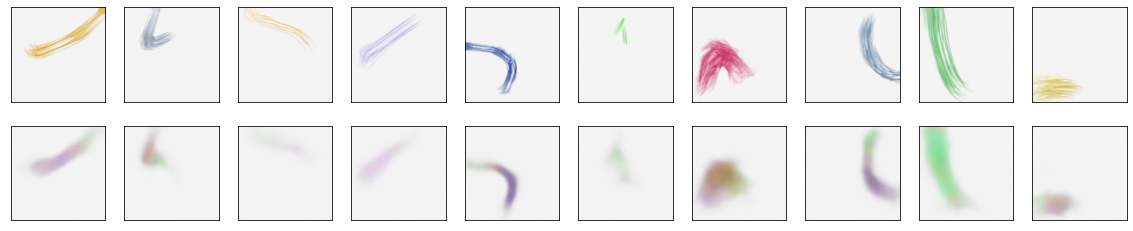

In [ ]:
batch = generador_norm_punt_inter.__next__()
pred = model_resnet_decov_punt_inter.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Observamos que los resultados son un poco malos ya que aunque aprende de la trayectoria no aprende muy bien el color y nada del pincel.

## U-NET

A continuación, vamos a definir la arquitectura de la U-Net. Dicha arquitectura ha sido tomada de *https://www.depends-on-the-definition.com/unet-keras-segmenting-images/* y adaptada a nuestro problema, es decir, debe de recibir como entrada un vector de dimensión 14 y como salida una imagen con 3 canales (RGB).

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(input_shape, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    features = Input(input_shape)
    a = Dense(32*32,activation="relu")(features)
    a1 = Reshape((32,32,1)) (a)
    c1 = conv2d_block(a1, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    u10 = UpSampling2D((4,4)) (c9)
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (u10)
    model = Model(features,outputs)
    return model

In [ ]:
u_net = get_unet(14)
u_net.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         15360       input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 32, 32, 1)    0           dense[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         reshape[0][0]                    
_______________________________________________________________________________________

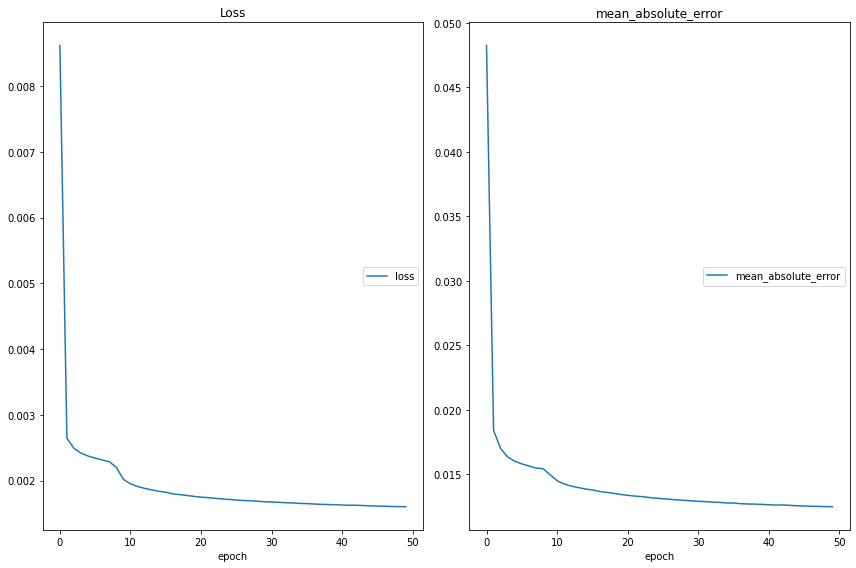

Loss
	loss             	 (min:    0.002, max:    0.009, cur:    0.002)
mean_absolute_error
	mean_absolute_error 	 (min:    0.012, max:    0.048, cur:    0.012)
1836/1836 [==============================] - 62s 34ms/step - loss: 0.0016 - mean_absolute_error: 0.0125


In [ ]:
u_net.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

u_net.fit_generator(generador_norm, epochs= 50, callbacks = [PlotLossesKeras()])

In [ ]:
batch = generador_norm.__next__()
pred = u_net.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos observar buenos resultados ya que en este caso aprende tanto de la trayectoria como del color y la transparencia. Lo malo es que esta red tampoco consigue aprender del pincel. A continuación, vamos a cambiar el loss y la métrica con el fin de intentar que aprenda también del pincel.

Vamos a guardar los pesos de esta red:

In [ ]:
model_json=u_net.to_json()
with open("u_net.json","w") as json_file:
    json_file.write(model_json)
u_net.save_weights("u_net.h5")

El siguiente código es para cargar la red guardada:

In [ ]:
json_file = open("u_net.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("u_net.h5")

loaded_model.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

### Variando el loss y la métrica

* **Loss:** binary_crossentropy;  **Métrica:** mean absolute error

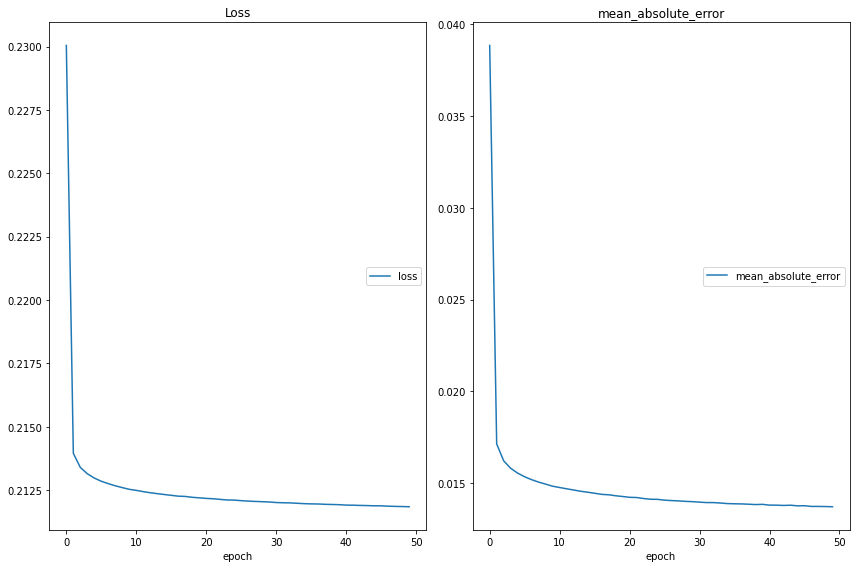

Loss
	loss             	 (min:    0.212, max:    0.230, cur:    0.212)
mean_absolute_error
	mean_absolute_error 	 (min:    0.014, max:    0.039, cur:    0.014)
1836/1836 [==============================] - 90s 49ms/step - loss: 0.2118 - mean_absolute_error: 0.0137


In [ ]:
u_net.compile(
      optimizer=Adam(),
      loss=binary_crossentropy,
      metrics=['mean_absolute_error'],
    )

u_net.fit_generator(generador_norm, epochs= 50, callbacks = [PlotLossesKeras()])

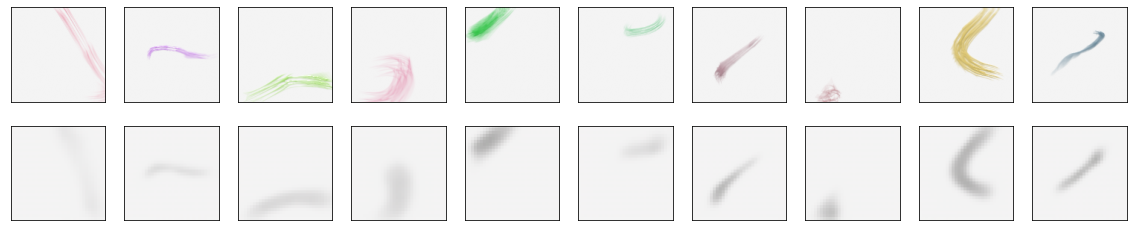

In [ ]:
batch = generador_norm.__next__()
pred = u_net.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Vemos que el haber cambiado el loss ha empeorado los resultados ya que ahora sólo aprende de la trayectoria.

### Utilizando los puntos intermedios

A continuación, vamos a volver a definir la red U-NET cambiando el tamaño de entrada a 28, con el fin de intentar conseguir mejores resultados de la pincelada.

In [ ]:
u_net_punt_inter = get_unet(28)
u_net_punt_inter.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1024)         29696       input_3[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 32, 32, 1)    0           dense_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 32, 32, 16)   160         reshape_3[0][0]                  
_______________________________________________________________________________________

In [ ]:
u_net_punt_inter.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

u_net_punt_inter.fit_generator(generador_norm_punt_inter, epochs= 50, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.002, max:    0.009, cur:    0.002)
mean_absolute_error
	mean_absolute_error 	 (min:    0.014, max:    0.050, cur:    0.014)
1836/1836 [==============================] - 87s 47ms/step - loss: 0.0021 - mean_absolute_error: 0.0143


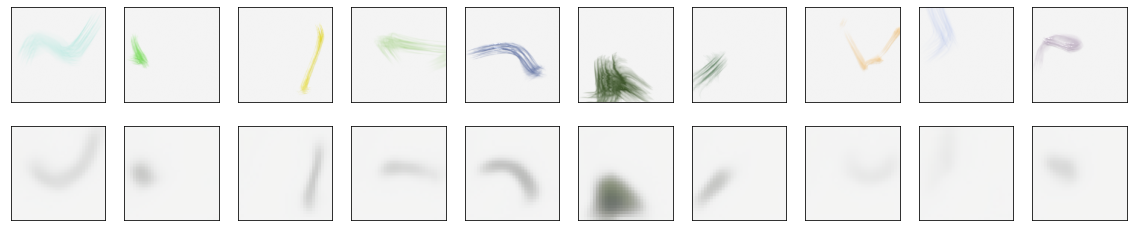

In [ ]:
batch = generador_norm_punt_inter.__next__()
pred = u_net_punt_inter.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos observar que los resultados no son demasiados buenos ya que lo único que aprende es la trayectoria y además está un poco borroso. Esto se puede reflejar en la gráfica del loss ya que a partir de la décima época apenas se reduce por lo que la red ha aprendido bastante poco.

## Autoencoder 

A continuación, vamos a definir la arquitectura del autoencoder. Dicha arquitectura ha sido tomada del notebook *Autoencodificadores.ipynb* de clase. En este caso debe recibir la imagen de la pincelada con los 3 canales y como salida la misma imagen con los 3 canales.

Al ser de otro tipo de mode, tenemos que usar el generador con mode igual a *ae* (**generador_ae**).

In [ ]:
class Autoencoder:
    
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,
                 decoder_conv_filters, decoder_conv_kernel_size, decoder_conv_strides, activation, z_dim,
                 use_batch_normalization=False, dropout = None):
    
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides
        self.z_dim = z_dim
        self.activation = activation
        self.use_batch_normalization = use_batch_normalization
        self.dropout = dropout
        
        self.encoder, encoder_input, encoder_output = self.__create_encoder() 
        self.decoder = self.__create_decoder()
        self.model = Model(encoder_input, self.decoder(encoder_output))
        
    def __create_encoder(self):

        encoder_input = Input(shape=self.input_dim, name='encoder_input') 
        x = encoder_input
        for i in range(len(self.encoder_conv_filters)):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i],
                kernel_size = self.encoder_conv_kernel_size[i],
                strides = self.encoder_conv_strides[i],
                padding = 'same',
                activation = self.activation if isinstance(self.activation, str) else None,
                name = 'encoder_conv_' + str(i)
            )
 
            x = conv_layer(x) #(2)
    
            if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                x = self.activation()(x)
                
            if self.use_batch_normalization:
                x = BatchNormalization()(x)

            if self.dropout:
                x = Dropout(self.dropout)(x)                

        self.__shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x) #(3)
        
        encoder_output = self._create_latent_vector(encoder_input, x)
        
        return Model(encoder_input, encoder_output), encoder_input, encoder_output #(5)
        
    def _create_latent_vector(self, encoder_input, x):
        encoder_output= Dense(self.z_dim, name='encoder_output')(x) 
        return encoder_output
    
    
    def __create_decoder(self):

        decoder_input = Input(shape=(self.z_dim,), name='decoder_input') #(1)
        
        x = Dense(np.prod(self.__shape_before_flattening))(decoder_input) #(2)
        
        
        x = Reshape(self.__shape_before_flattening)(x) #(3)
        
        for i in range(len(self.decoder_conv_filters)):
            activation = self.activation if isinstance(self.activation, str) else None
            conv_layer = Conv2DTranspose(
                filters = self.decoder_conv_filters[i],
                kernel_size = self.decoder_conv_kernel_size[i],
                strides = self.decoder_conv_strides[i],
                padding = 'same',
                activation = activation if i < len(self.decoder_conv_filters)-1 else 'sigmoid',
                name = 'decoder_conv_' + str(i)
            )
 
            x = conv_layer(x) #(4)
    
            if i < len(self.decoder_conv_filters)-1:
                if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                    x = self.activation()(x)

                if self.use_batch_normalization:
                    x = BatchNormalization()(x)

                if self.dropout:
                    x = Dropout(self.dropout)(x)                
            
            
        decoder_output = x
        
        return Model(decoder_input, decoder_output) #(6)
    

In [ ]:
AE = Autoencoder(
    input_dim = (128,128,3)
    , encoder_conv_filters = [32,32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3,3]
    , encoder_conv_strides = [1,2,2,2,1]
    , decoder_conv_filters = [64,64,64,32,3]
    , decoder_conv_kernel_size = [3,3,3,3,3]
    , decoder_conv_strides = [1,2,2,2,1]
    , activation = 'relu'
    , z_dim = 200
    , use_batch_normalization=False)

In [ ]:
AE.encoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 128, 128, 3)]     0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 128, 128, 32)      896       
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 64, 64, 32)        9248      
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
encoder_conv_4 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [ ]:
AE.decoder.summary()

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 16384)             3293184   
_________________________________________________________________
reshape_6 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 64, 64, 64)        36928     
_________________________________________________________________
decoder_conv_3 (Conv2DTransp (None, 128, 128, 32)    

In [ ]:
AE.model.compile(optimizer= Adam(), 
                 loss = binary_crossentropy, metrics=['mean_absolute_error'])

In [ ]:
AE.model.fit_generator(generador_ae, epochs= 50, callbacks = [PlotLossesKeras()])

Loss
	loss             	 (min:    0.206, max:    0.222, cur:    0.206)
mean_absolute_error
	mean_absolute_error 	 (min:    0.005, max:    0.025, cur:    0.005)
1836/1836 [==============================] - 85s 46ms/step - loss: 0.2062 - mean_absolute_error: 0.0051


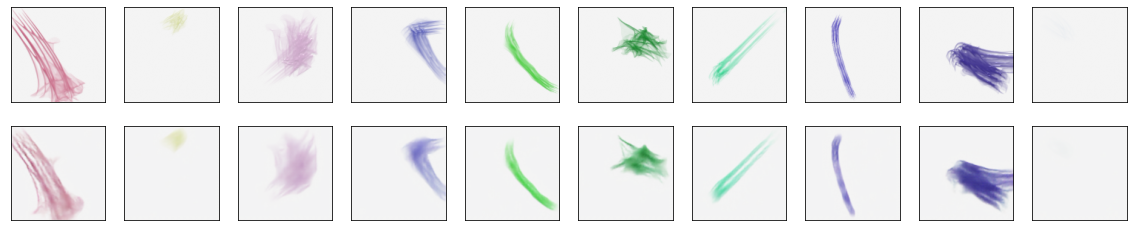

In [ ]:
batch = generador_ae.__next__()
pred = AE.model.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

In [ ]:
batch = generador_ae.__next__()
pred = AE.model.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

A continuación, vamos a guardar los pesos de esta red:

In [ ]:
model_json=AE.model.to_json()
with open("AE.json","w") as json_file:
    json_file.write(model_json)
AE.model.save_weights("autoencoder.h5")

El siguiente código es para cargar la red guardada:

In [ ]:
json_file = open("AE.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("autoencoder.h5")

loaded_model.compile(optimizer= Adam(), loss = binary_crossentropy, metrics=['mean_absolute_error'])

Podemos ver que los resultados son bastantes buenos ya que esta red ha aprendido tanto de la trayectoria como del color, transparencia y del pincel, cosa que las demás redes no han conseguido. Todo esto se refleja en el buen EAM que ha conseguido (0.005).

## Conditional Autoencoder

A continuación, vamos a definir la arquitectura del conditional autoencoder. En este caso debe recibir la imagen de la pincelada con los 3 canales y el vector de características de tamaño 14 y como salida una imagen de la pincelada correspondiente con los 3 canales.

Esta red se diferencia del autoencoder en que le introducimos a la red además de la imagen el vector de las características y además ese vector lo unimos al vector lantente generado por el encoder.

Al ser de otro tipo de mode, tenemos que usar el generador con mode igual a *cae* (**generador_norm_cae**).

In [ ]:
features = Input(14,)
pincelada = Input((128,128,3))
a = Dense(128*128,activation="relu")(features)
a1 = Reshape((128,128,1)) (a)
a2 = Conv2D(1, (3, 3), padding='same')(a1)
a3 = Activation('relu')(a2)

y = Concatenate()([pincelada,a3])
#Codificador

y =  Conv2D( filters = 32,
                kernel_size = 3,
                strides = 1,
                padding = 'same',
                name = 'encoder_conv_1' 
            )(y)
y = LeakyReLU()(y)
y =  Conv2D( filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_2' 
            )(y)
y = LeakyReLU()(y)
y =  Conv2D( filters = 64,
                kernel_size = 3,
                strides = 2,
                padding = 'same',
                name = 'encoder_conv_3' 
            )(y)
y = LeakyReLU()(y)
y =  Conv2D( filters = 64,
                kernel_size = 3,
                strides = 1,
                padding = 'same',
                name = 'encoder_conv_4' 
            )(y)
y = LeakyReLU()(y)
y = Flatten()(y)
salida_encoder = Dense(14,name='encoder_output')(y)
z = Concatenate()([features,salida_encoder])

#Desodificador
x = Dense(8*8*64,activation='relu')(z)
x = Reshape((8,8,64))(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization()(x)
salida_decoder =  Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_5'
            )(x)

conditional_ae = Model([pincelada,features],salida_decoder)
conditional_ae.summary()


Model: "functional_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_48 (Dense)                (None, 16384)        245760      input_39[0][0]                   
__________________________________________________________________________________________________
reshape_30 (Reshape)            (None, 128, 128, 1)  0           dense_48[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 1)  10          reshape_30[0][0]                 
______________________________________________________________________________________

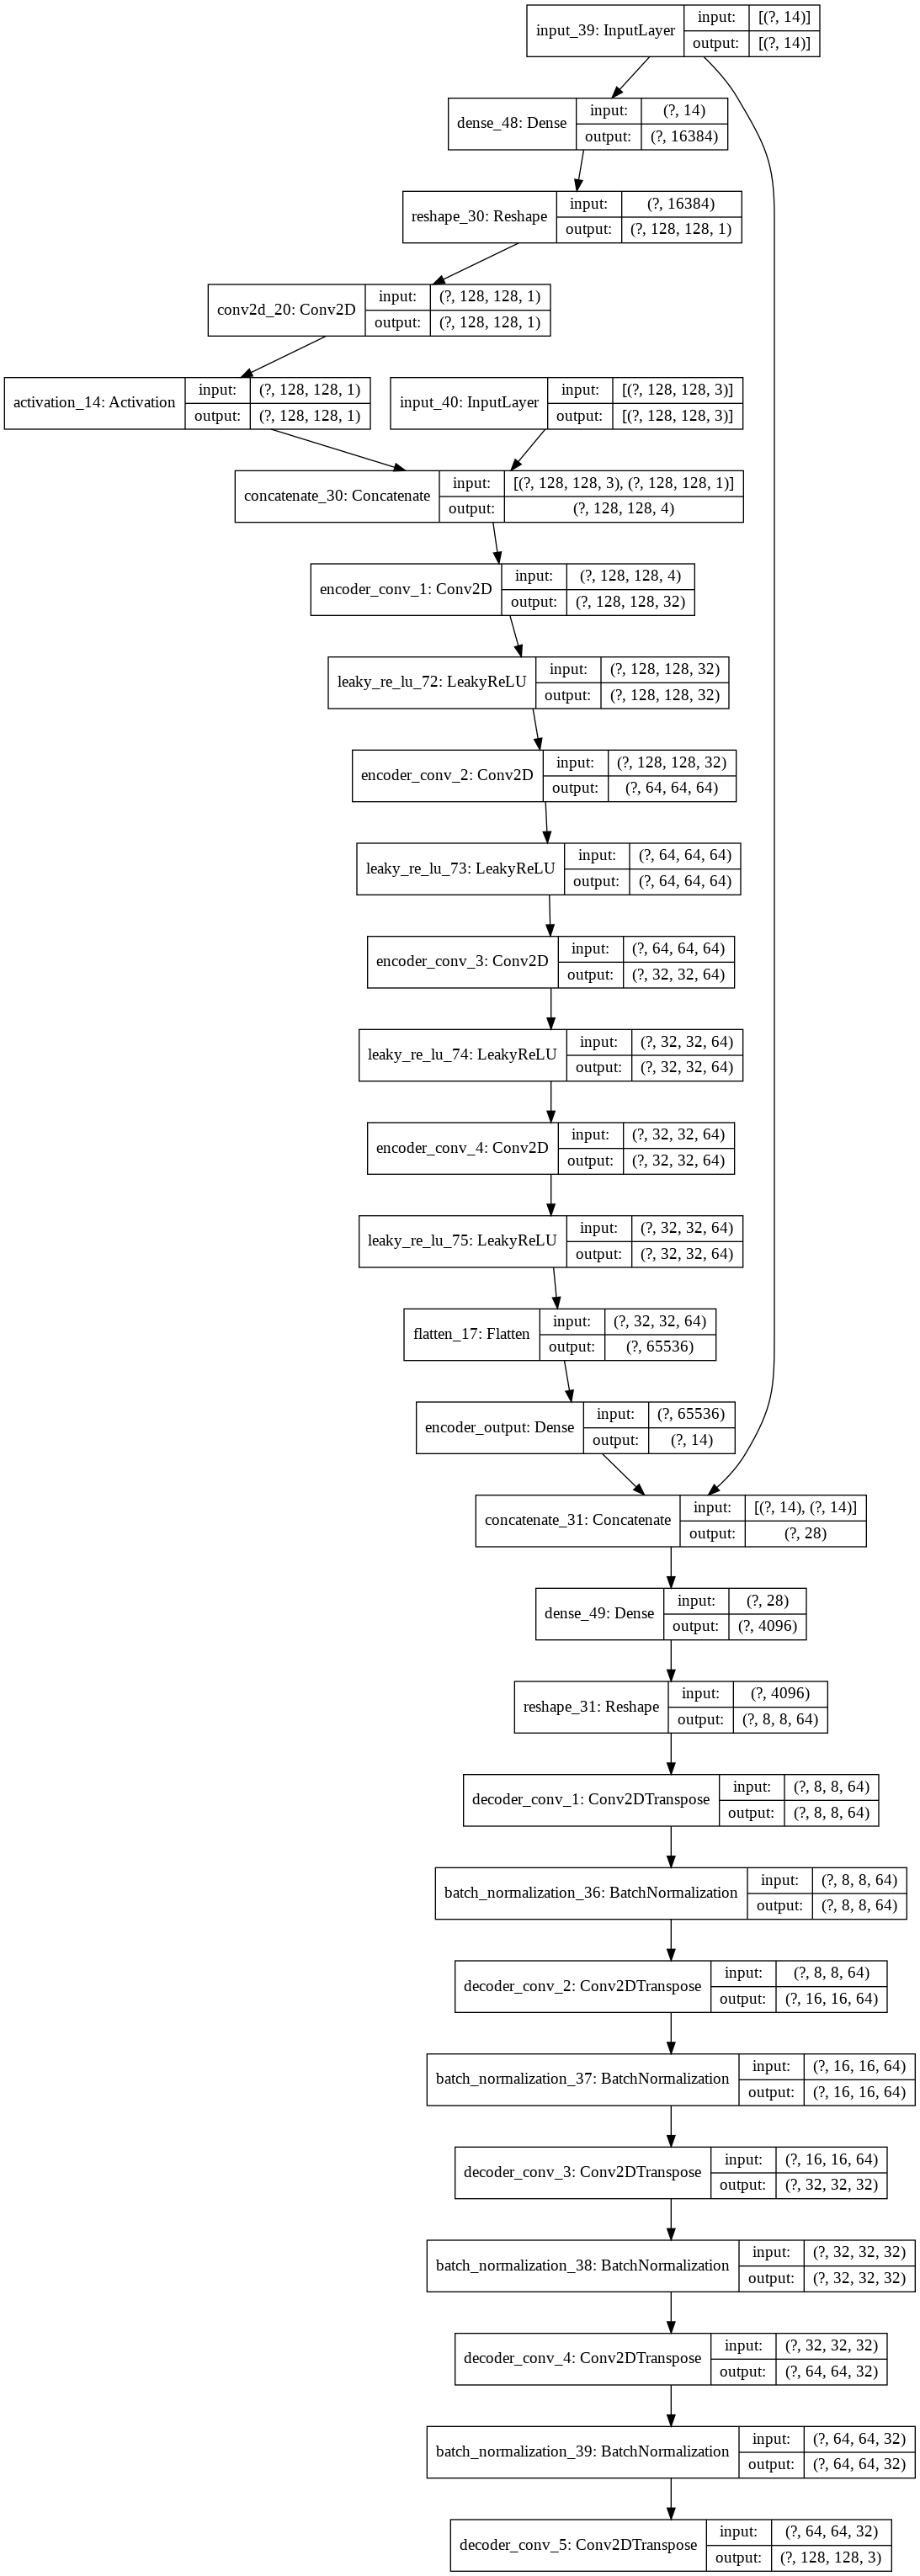

In [ ]:
plot_model(conditional_ae, show_shapes=True, show_layer_names=True)

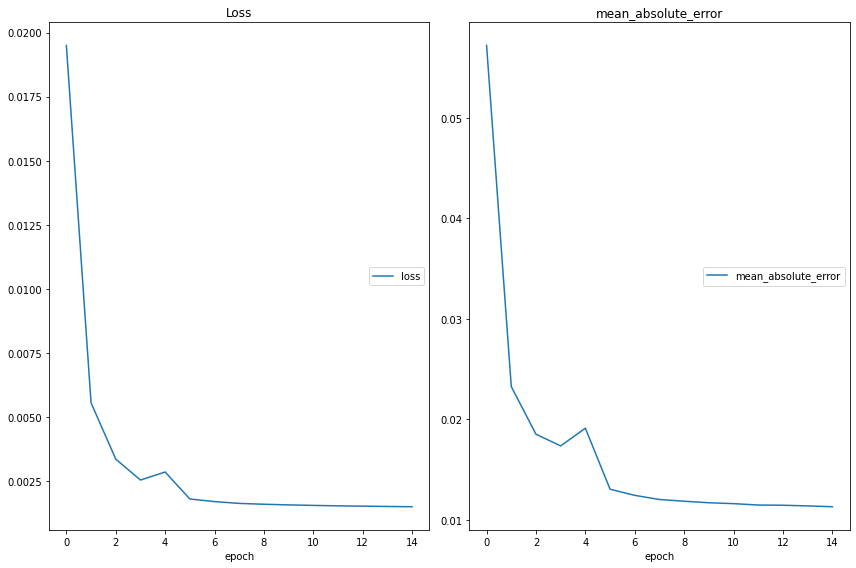

Loss
	loss             	 (min:    0.001, max:    0.019, cur:    0.001)
mean_absolute_error
	mean_absolute_error 	 (min:    0.011, max:    0.057, cur:    0.011)
1836/1836 [==============================] - 163s 89ms/step - loss: 0.0015 - mean_absolute_error: 0.0113


In [ ]:
conditional_ae.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=['mean_absolute_error'],
    )

conditional_ae.fit_generator(generador_norm_cae, epochs= 15, callbacks = [PlotLossesKeras()])

In [ ]:
batch = generador_norm_cae.__next__()
pred = conditional_ae.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos ver que en este caso aprende bastante bien de la trayectoria pero no del color ni pincel. A continuación, vamos a variar el loss y la métrica con el fin de conseguir mejores resultados.

### Variando el loss y la métrica

* **Loss**: Mean squared error; **Métrica**: ssim_loss

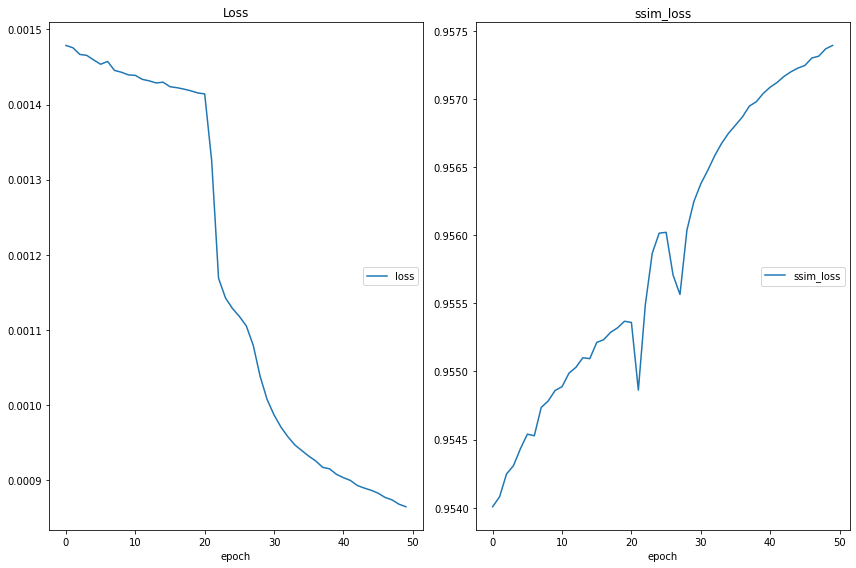

Loss
	loss             	 (min:    0.001, max:    0.001, cur:    0.001)
ssim_loss
	ssim_loss        	 (min:    0.954, max:    0.957, cur:    0.957)
1836/1836 [==============================] - 194s 106ms/step - loss: 8.6449e-04 - ssim_loss: 0.9574


In [ ]:
conditional_ae.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=[ssim_loss],
    )

conditional_ae.fit_generator(generador_norm_cae, epochs= 50, callbacks = [PlotLossesKeras()])

In [ ]:
batch = generador_norm_cae.__next__()
pred = conditional_ae.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Podemos observar unos resultados bastante mejores que antes. En este caso aprende tanto de la trayectoria como del color bastante bien, eso si, del pincel no aprende. A continuación, vamos a variar el loss y la métrica con el fin de que la red obtenga mejores resultados.

Vamos a guardar los pesos de esta red:

In [ ]:
model_json=conditional_ae.to_json()
with open("cae.json","w") as json_file:
    json_file.write(model_json)
conditional_ae.save_weights("cae.h5")

El siguiente código es para cargar la red guardada:

In [ ]:
json_file = open("cae.json","r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights("cae.h5")

loaded_model.compile(
      optimizer=Adam(),
      loss='mean_squared_error',
      metrics=[ssim_loss],
    )

* **Loss:** MSE + cosine_similarity; **Métrica:** ssim_loss

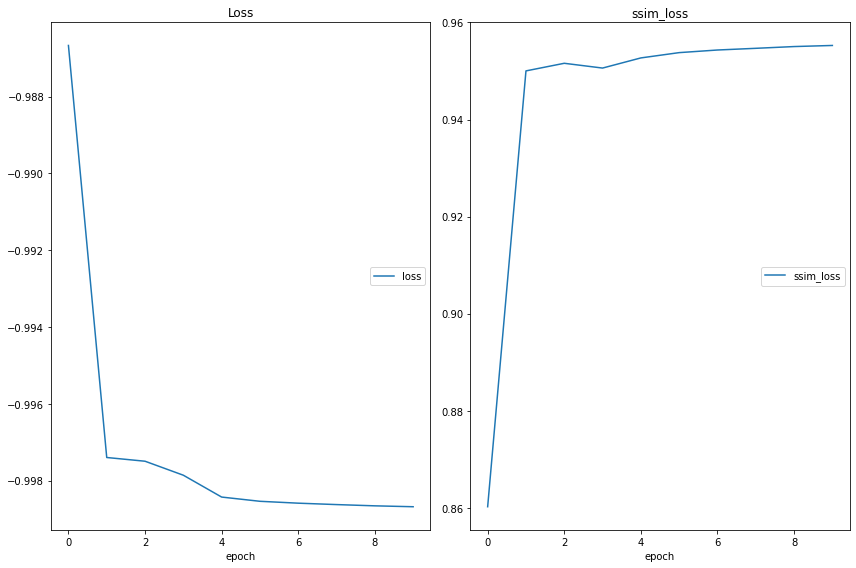

Loss
	loss             	 (min:   -0.999, max:   -0.987, cur:   -0.999)
ssim_loss
	ssim_loss        	 (min:    0.860, max:    0.955, cur:    0.955)
1836/1836 [==============================] - 88s 48ms/step - loss: -0.9987 - ssim_loss: 0.9553


In [ ]:
conditional_ae.compile(
      optimizer=Adam(lr=0.001),
      loss= MSE_cosine_similarity,
      metrics=[ssim_loss],
    )

conditional_ae.fit_generator(generador_norm_cae, epochs= 10, callbacks = [PlotLossesKeras()])

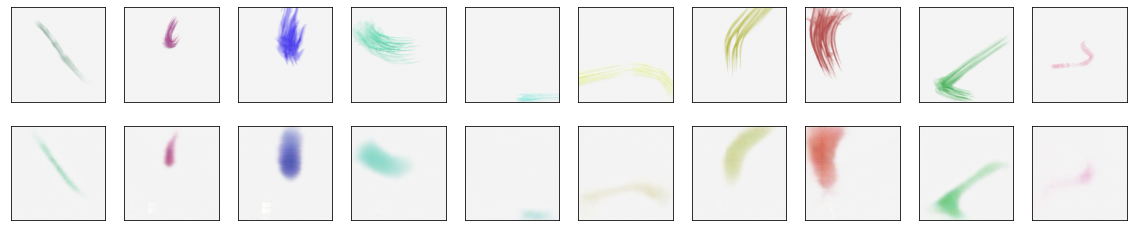

In [ ]:
batch = generador_norm_cae.__next__()
pred = conditional_ae.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Volvemos a tener buenos resultados excepto por el pincel.

* **Loss:** MSE + ssim_loss; **Métrica:** cosine_similarity

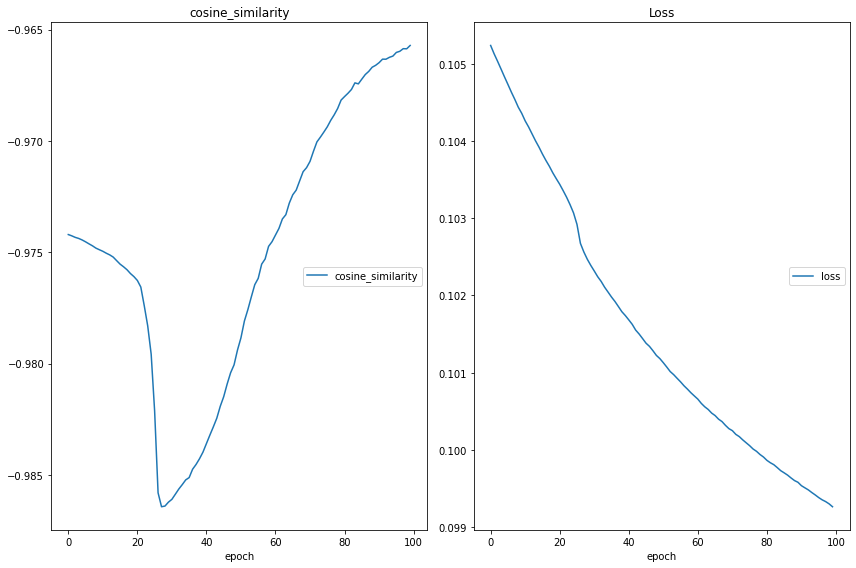

cosine_similarity
	cosine_similarity 	 (min:   -0.986, max:   -0.966, cur:   -0.966)
Loss
	loss             	 (min:    0.099, max:    0.105, cur:    0.099)
1836/1836 [==============================] - 102s 55ms/step - loss: 0.0993 - cosine_similarity: -0.9657


In [ ]:
conditional_ae.compile(
      optimizer= Adam(), 
      loss= MSE_ssim_loss,
      metrics=[cosine_similarity],
    )

conditional_ae.fit_generator(generador_norm_cae, epochs= 100, callbacks = [PlotLossesKeras()])

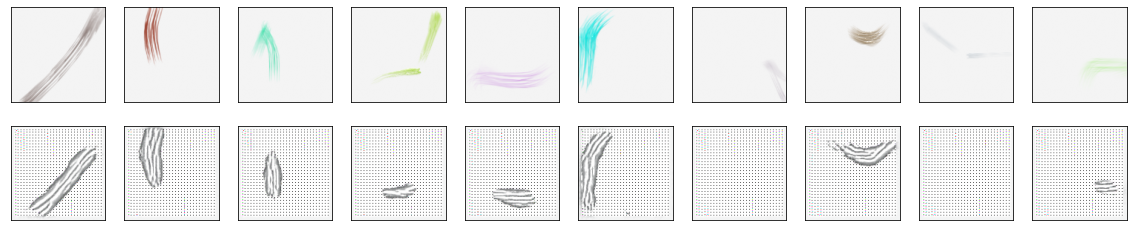

In [ ]:
batch = generador_norm_cae.__next__()
pred = conditional_ae.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

En este caso vemos que aprende de la trayectoria en la mayoría y de los hilos del pincel, sin embargo, hemos perdido el color.

## GAN


A continuación, vamos a definir la arquitectura de la GAN. Los siguientes códigos han sido obtenidos de https://anderfernandez.com/blog/como-crear-una-red-generativa-antagonica-gan-en-python/ adaptándolos a nuestro objetivo del problema. Es decir, hemos adaptado la red generativa para que como entrada tenga un vector de tamaño 14 y como salida devuelva una imagen de tamaño (128,128,3) y la red discriminadora reciba imágenes de ese tamaño. Además, hemos tenido que adaptar el código para utilizar el generador de pinceladas.

Comenzamos definiendo la red **generativa**:

In [ ]:
features = Input(shape=(14,))
x = Dense(4096,activation="relu")(features)
x = Reshape((8,8,64))(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 1,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_1' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 64,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_2' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_3' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 32,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'relu',
                name = 'decoder_conv_4' 
            )(x)
x = BatchNormalization()(x)
x =  Conv2DTranspose(
                filters = 3,
                kernel_size = (3,3),
                strides = 2,
                padding = 'same',
                activation = 'sigmoid',
                name = 'decoder_conv_5'
            )(x)
x = BatchNormalization()(x)
# x = Dropout(self.dropout)(x)

modelo_generador = Model(features, x)
modelo_generador.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              61440     
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
decoder_conv_2 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)       

Una vez que tenemos definido la red generativa, vamos a comprobar que funciona correctamente. Para ello, vamos a generar varios vectores de características y lo introducimos a la red.

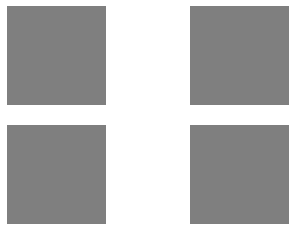

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(generador_imag,n_muestras):
  ix = np.random.randint(0, generador_imag.batch_size, n_muestras)
  X = generador_imag.__next__()[0][ix]
  return X

def crear_datos_fake(modelo_generador,generador_imag,n_muestras):
  input = generar_datos_entrada(generador_imag,n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

generador_imag= StrokeInMemoryIterator(im_bytes, strokes_norm, 4, mode='stroke', shuffle=True)
X,_ = crear_datos_fake(modelo_generador, generador_imag,4)

# Visualizamos resultados
for i in range(generador_imag.batch_size):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])

A continuación, definimos la red **discriminadora**:


In [ ]:
def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (128,128,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    # discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    # discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    # discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 128)       0

* **Pre entrenamiento de la red discriminadora**

In [ ]:
import random

def cargar_datos_reales(generador_imag, n_muestras):
  ix = np.random.randint(0, generador_imag.batch_size, n_muestras)
  X = generador_imag.__next__()[1][ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(128 * 128 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 128,128,3))
  y = np.zeros((n_muestras, 1))
  return X,y

In [ ]:
def entrenar_discriminador(modelo, generador_imag, epoch=20):
  batch= generador_imag.batch_size
  medio_batch = int(batch/2)

  for i in range(epoch):
    X_real, y_real = cargar_datos_reales(generador_imag, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [ ]:
generador_imag = StrokeInMemoryIterator(im_bytes, strokes_norm, 128, mode='stroke', shuffle=True)
entrenar_discriminador(modelo_discriminador, generador_imag)

1 Real:50.0, Fake:0.0
2 Real:100.0, Fake:0.0
3 Real:100.0, Fake:95.3125
4 Real:100.0, Fake:100.0
5 Real:100.0, Fake:100.0
6 Real:100.0, Fake:100.0
7 Real:100.0, Fake:100.0
8 Real:100.0, Fake:100.0
9 Real:100.0, Fake:100.0
10 Real:100.0, Fake:100.0
11 Real:100.0, Fake:100.0
12 Real:100.0, Fake:100.0
13 Real:100.0, Fake:100.0
14 Real:100.0, Fake:100.0
15 Real:100.0, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:100.0, Fake:100.0
18 Real:100.0, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


Una vez pre entrenada la red **discriminadora**, vamos a proceder a la construcción de la **gan**:

In [ ]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 128, 128, 3)       164655    
_________________________________________________________________
sequential (Sequential)      (None, 1)                 583937    
Total params: 748,592
Trainable params: 164,265
Non-trainable params: 584,327
_________________________________________________________________


Definimos ahora la función para entrenar nuestra red.

In [ ]:
def entrenamiento(generador_img, modelo_generador, modelo_discriminador, epochs, inicio = 0):
  n_batch=generador_img.batch_size
  # dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # Iteramos para todos los epochs
  for epoch in range(inicio, inicio + epochs):
    # Iteramos para todos los batches
    for batch in range(n_batch):

      # Cargamos datos reales
      X_real,Y_real = cargar_datos_reales(generador_img, medio_dataset)


      # Entrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(modelo_generador,generador_img,medio_dataset)

      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # Generamos datos de entadas de la GAN
      X_gan = generar_datos_entrada(generador_img,medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # Entrenamos la GAN con datos falsos
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Resumen loss on this batch
    print('>%d, loss_real=%.3f, loss_fake=%.3f loss_gan=%.3f' %
					(epoch+1,coste_discriminador_real, coste_discriminador_fake, coste_gan))
    # Generamos nuevos datos
    X_real,Y_real = cargar_datos_reales(generador_img, medio_dataset)
    X_fake, Y_fake =  crear_datos_fake(modelo_generador,generador_img,medio_dataset)

    # Evaluamos el modelo
    _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
    _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

    print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')
    print('\n')
      # print('\n')
    # # Cada 10 Epochs mostramos resultados y el coste
    # if (epoch+1) % 10 == 0:
    #   evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
    #   mostrar_imagenes_generadas(X_fake, epoch = epoch)

In [ ]:
generador_img = StrokeInMemoryIterator(im_bytes, strokes_norm, 64, mode='stroke', shuffle=True)
entrenamiento(generador_img, modelo_generador, modelo_discriminador, epochs = 200, inicio = 0)

>1, loss_real=0.198, loss_fake=0.566 loss_gan=4.598
1/1 [==============================] - 0s 44ms/step - loss: 0.2961 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%


>2, loss_real=0.002, loss_fake=0.001 loss_gan=9.171
1/1 [==============================] - 0s 47ms/step - loss: 0.0013 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%


>3, loss_real=0.000, loss_fake=0.000 loss_gan=10.158
1/1 [==============================] - 0s 43ms/step - loss: 3.7314e-04 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%


>4, loss_real=0.000, loss_fake=0.000 loss_gan=12.631
1/1 [==============================] - 0s 45ms/step - loss: 7.4529e-05 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%


>5, loss_real=0.000, loss_fake=0.000 loss_gan=13.304
1/1 [==============================] - 0s 46ms/step - loss: 3.2128e-05 - accuracy: 1.0000
Acc Real:100.0% Acc Fake:100.0%


>6, loss_real=0.000, loss_fake=0.000 loss_gan=13.750
1/1 [==============================] - 0s 45ms/step - loss: 3.2191e-05 -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


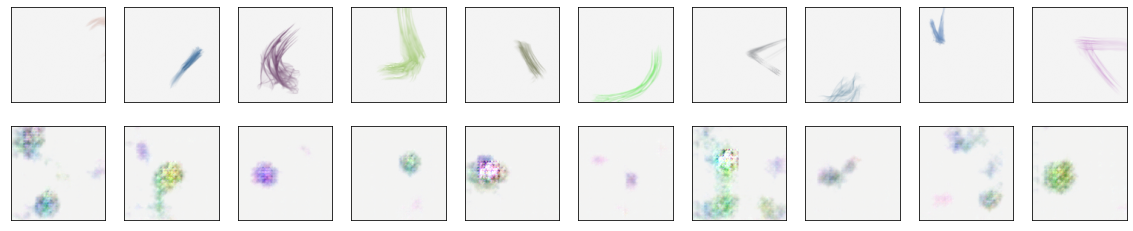

In [ ]:
batch = generador_img.__next__()
pred = modelo_generador.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

Como podemos ver la red generativa no ha aprendido sobre la pincelada.

## Conditional GAN


A continuación, vamos a definir la arquitectura de la GAN condicional. Los siguientes códigos han sido obtenidos de https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/ adaptándolos a nuestro objetivo del problema. Es decir, de la misma manera que la red gan, hemos tenido que adaptar  la red generativa para que como entrada tenga un vector de tamaño 14 y como salida devuelva una imagen de tamaño (128,128,3) y la red discriminadora reciba imágenes de ese tamaño. Además, hemos tenido que adaptar el código para utilizar el generador de pinceladas.

La diferencia de esta red con la anterior es que como entrada del generador recibe tanto un vector aleatorio de tamaño 200 como el vector de características y como entrada del discriminador, además de la imagen, recibe el vector de características.

In [ ]:
def define_discriminator(in_shape=(128,128,3)):
  #Entrada de las características pincelada
  features = Input((14,)) 
  x = Dense(128*128,activation="relu")(features)
  x = Reshape((128,128,1))(x)
  # image input
  in_image = Input(shape=in_shape)
	# concat 
  merge = Concatenate()([in_image, x])
  # downsample
  fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(merge)
  fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
  fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  # downsample
  fe = Conv2D(256, (3,3), strides=(2,2), padding='same')(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
  fe = Flatten()(fe)
	# dropout
  fe = Dropout(0.4)(fe)
	# output
  out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
  model = Model([in_image, features], out_layer)
	# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
define_discriminator().summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 16384)        245760      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 128, 128, 1)  0           dense[0][0]                      
_______________________________________________________________________________________

In [ ]:
def define_generator(latent_dim, features_dim = 14):
    # label input
  in_lat = Input(shape=(latent_dim,))
    # linear multiplication
  n_nodes = 8*8
  li = Dense(n_nodes)(in_lat)
    # reshape to additional channel
  li = Reshape((8, 8, 1))(li)
    # image generator input
  features= Input(shape=(features_dim,))
    # foundation for 8x8 image
  n_nodes = 8*8*64
  gen = Dense(n_nodes)(features)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((8,8,64))(gen)
    # merge 
  merge = Concatenate()([gen, li])
  gen = Conv2DTranspose(64, (3,3), strides=1,activation='relu', padding='same')(merge)
  gen = Conv2DTranspose(64, (3,3), strides=2,activation='relu', padding='same')(gen)
  gen = Conv2DTranspose(32, (3,3), strides=2,activation='relu', padding='same')(gen)
  gen = Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(gen)
    # output
  out_layer = Conv2DTranspose(3, (3,3), strides=2, activation='tanh', padding='same')(gen)
    # define model
  model = Model([in_lat, features], out_layer)
  return model

In [ ]:
define_generator(200).summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 4096)         61440       input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
leaky_re_lu_4 (LeakyReLU)       (None, 4096)         0           dense_3[0][0]                    
_______________________________________________________________________________________

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and features inputs from generator model
	gen_noise, features = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and feautes input from generator as inputs to discriminator
	gan_output = d_model([gen_output, features])
	# define gan model as taking noise and features and outputting a classification
	model = Model([gen_noise, features], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
define_gan(define_generator(200),define_discriminator()).summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 14)]         0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 4096)         61440       input_6[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 4096)         0           dense_5[0][0]                    
_______________________________________________________________________________________

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(batch,latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
		# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
		# generate features
	features = batch[0][:(n_samples)]
	return [z_input, features]
 

def generate_real_samples(batch, n_samples):
		features = batch[0][:(n_samples)]
		imagenes_features = batch[1][:(n_samples)]
			# generate class labels
		y = ones((n_samples, 1))
		return [imagenes_features,features], y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator,batch, latent_dim, n_samples):
		# generate points in latent space and features
		z_input, features = generate_latent_points(batch,latent_dim, n_samples)
			# predict outputs
		images = generator.predict([z_input, features])
			# create class labels
		y = zeros((n_samples, 1))
		return [images, features], y

In [ ]:
def train(g_model, d_model, gan_model, latent_dim, generador_img, n_epochs=500):
		n_batch = generador_img.batch_size
		bat_per_epo = int(n_batch)
		half_batch = int(n_batch / 2)
			# manually enumerate epochs
		for i in range(n_epochs):
			batch = generador_img.__next__()
				# enumerate batches over the training set
			for j in range(bat_per_epo):
					# get randomly selected 'real' samples
				[images_real,features], y_real = generate_real_samples(batch, half_batch)
					# update discriminator model weights
				d_loss1, _ = d_model.train_on_batch([images_real,features], y_real)
					# generate 'fake' examples
				[images_fake, features], y_fake = generate_fake_samples(g_model, batch,latent_dim, half_batch)
					# update discriminator model weights
				d_loss2, _ = d_model.train_on_batch([images_fake, features], y_fake)
					# prepare points in latent space as input for the generator
				[z_input, features] = generate_latent_points(batch,latent_dim, n_batch)
					# create inverted labels for the fake samples
				y_gan = ones((n_batch, 1))
					# update the generator via the discriminator's error
				g_loss = gan_model.train_on_batch([z_input, features], y_gan)
					# summarize loss on this batch
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
					(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
			# save the generator model
		g_model.save('cgan_generator.h5')

In [ ]:
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
# size of the latent space
latent_dim = 200
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
#generador
generador_img = StrokeInMemoryIterator(im_bytes, strokes_norm, 64, mode='stroke', shuffle=True)
# train model
train(g_model, d_model, gan_model, latent_dim, generador_img)

Se han truncado las últimas 5000 líneas del flujo de salida.
>422, 58/64, d1=0.104, d2=0.075 g=3.320
>422, 59/64, d1=0.084, d2=0.098 g=3.352
>422, 60/64, d1=0.051, d2=0.102 g=3.560
>422, 61/64, d1=0.125, d2=0.103 g=3.114
>422, 62/64, d1=0.065, d2=0.153 g=3.493
>422, 63/64, d1=0.195, d2=0.175 g=3.209
>422, 64/64, d1=0.076, d2=0.184 g=3.823
>423, 1/64, d1=7.165, d2=1.475 g=6.400
>423, 2/64, d1=1.792, d2=0.764 g=4.648
>423, 3/64, d1=0.867, d2=0.129 g=3.765
>423, 4/64, d1=0.283, d2=0.384 g=3.874
>423, 5/64, d1=0.287, d2=0.303 g=4.084
>423, 6/64, d1=0.328, d2=0.216 g=3.583
>423, 7/64, d1=0.155, d2=0.203 g=3.633
>423, 8/64, d1=0.153, d2=0.150 g=3.493
>423, 9/64, d1=0.138, d2=0.206 g=3.340
>423, 10/64, d1=0.130, d2=0.137 g=3.232
>423, 11/64, d1=0.127, d2=0.225 g=3.294
>423, 12/64, d1=0.198, d2=0.205 g=3.563
>423, 13/64, d1=0.185, d2=0.164 g=3.149
>423, 14/64, d1=0.078, d2=0.171 g=3.525
>423, 15/64, d1=0.136, d2=0.095 g=3.165
>423, 16/64, d1=0.093, d2=0.166 g=3.226
>423, 17/64, d1=0.108, d2=0.

In [ ]:
batch = generador_img.__next__()

def generate_latent_points(generador_img,latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
		# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
		# generate features
	features = batch[0][:n_samples]
	return [z_input, features]

model = load_model('cgan_generator.h5')
# generate images
latent_points, features = generate_latent_points(generador_img,200, 10)

# generate images
pred = model.predict([latent_points, features])
draw2compare(batch[1][:10], pred)

Observamos que la red generativa no ha aprendido de la pincelada.

He de decir que el entrenamiento de estas dos últimas redes son bastante difíciles y costosas y tras varios días intentando mejorar las estructuras de las redes o  los optimizadores o incluso cargando más épocas, no he conseguido nada mejor en ninguno de los dos casos. Por tanto, no he guardado ninguno de los dos modelos.

## Resumen

Como resumen final, vamos a mostrar los mejores resultados obtenidos a lo largo de este trabajo:

* **Autoencoder: Descodificador**

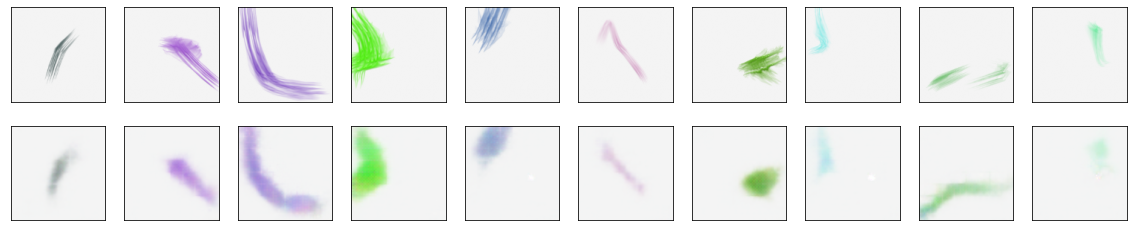

In [ ]:
batch = generador_norm.__next__()
pred = decoder.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

* **ResNet con deconvoluciones**

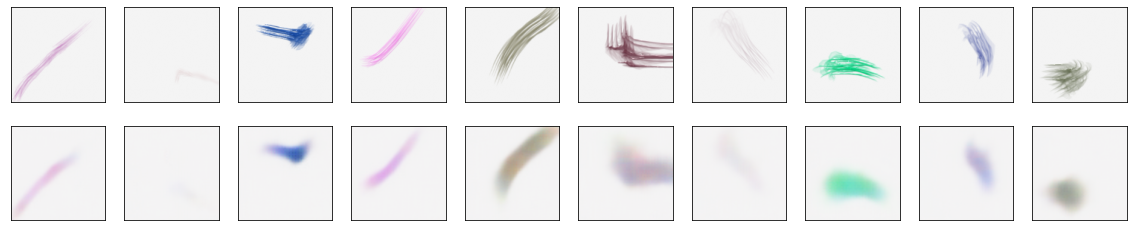

In [ ]:
batch = generador_norm_rgb.__next__()
pred = model_resnet_decov.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

* **U-NET**

In [ ]:
batch = generador_norm.__next__()
pred = u_net.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

* **Conditional Autoencoder**

In [ ]:
batch = generador_norm_cae.__next__()
pred = conditional_ae.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)

* **Autoencoder** 

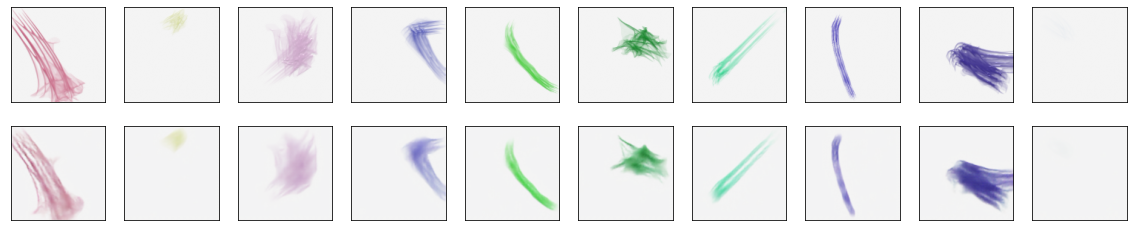

In [ ]:
batch = generador_ae.__next__()
pred = AE.model.predict(batch[0][:10])
draw2compare(batch[1][:10], pred)